In [154]:
import os
print(os.getcwd())

import sys
sys.path.append('../Utilities/src')
from DA_tools.DA_colors2 import *


import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import pandas as pd


import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


from numpy.random import normal,standard_t
from scipy.special import expit,logit
import scipy.stats as stats


/Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks


In [155]:
# from matplotlib.colors import to_hex

In [156]:
def mc_ecdf(x):
    N=len(x)
    srt_x = np.sort(x)
    values, counts = np.unique(srt_x, return_counts=True)
    probs = np.cumsum(counts/N)
    mc_se = np.sqrt(probs*np.abs(1-probs)/N)
    return values, probs, mc_se

def mc_hist(sample,bins='auto'):
    N=len(sample)
    hist,new_bins = np.histogram(sample,bins=bins)
    probs = hist/N
    mc_se = np.sqrt(probs*np.abs(1-probs)/N)
    return new_bins,probs,mc_se


def pad_hist_for_plot(bins,counts):
    if len(counts.shape)==1:
        ax=0
    else: ax=1
        
    xs = (np.repeat(bins,repeats=2))[1:-1]
    pad_counts = np.repeat(counts,repeats=2,axis=ax)
    return xs, pad_counts


def mc_ecdf_plot(values, probs, mc_se,ax=None):
    if ax is None:
        ax = plt.gca()
    ax.fill_between(values,probs-mc_se,probs+mc_se,color=LIGHT_HIGHLIGHT)
    ax.plot(values,probs,color=DARK)
    ax.set_ylabel('ECDF (Estimated Probabilities)')
    ax.set_xlabel('X')
    ax.set_xlim((min(values),max(values)))
    ax.set_xticks([min(values),np.median(values),max(values)])
    ax.set_yticks([0,0.25,0.5,0.75,1])
    return ax

def rolling_stats(sample):
    sample_series = pd.Series(sample)
    N=len(sample)
    sqrtNs = np.sqrt([*range(1,N+1)])
    rolling_mean = sample_series.expanding().mean().values
    rolling_mcse = sample_series.expanding().std().fillna(0).values/sqrtNs
    return rolling_mean, rolling_mcse

def mc_plot(rolling_mean, rolling_mcse,ax=None):
    if ax is None:
        ax = plt.gca()
    N=len(rolling_mean)
    ns = [*range(1,N+1)]
    colortab = [LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT]
    for i in range(3):
        ax.fill_between(ns,
                        rolling_mean-(3-i)*rolling_mcse,
                        rolling_mean+(3-i)*rolling_mcse,
                        color=colortab[i])
    ax.plot(ns,rolling_mean,color=DARK)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('Monte Carlo Estimator')
    ax.set_xlim((0,N+1))
    return ax
    
def mc_hist_plot(new_bins, probs,mc_se,ax=None,scale=False):
    if ax is None:
        ax = plt.gca()
    if scale:
        bin_width = np.diff(new_bins)[-1]
        probs = probs/bin_width
        mc_se = mc_se/bin_width
    xs,pad_hist =  pad_hist_for_plot(new_bins,probs)
    _,up_bar =  pad_hist_for_plot(new_bins,probs+mc_se)
    _,low_bar =  pad_hist_for_plot(new_bins,probs-mc_se)
    ax.fill_between(xs,low_bar,up_bar,color=LIGHT_HIGHLIGHT)
    ax.plot(xs,pad_hist,color=DARK,linewidth = 1.5)
    ax.set_ylabel('Estimated Bin Probabilities')
    if scale:
        ax.set_ylabel('Estimated Bin Probabilities\n divided by bin width')
    ax.set_xlabel('X')
    return ax

# Data analytics

## Exploring distributions

### dr hab. inż. Jerzy Baranowski, Prof. AGH

## Managing expectations

- Main point of probabilistic compoutation is to compute an expectation of certain function of parameters. 

- It generally covers all kind of statistics

- Has many beneficial properties

## Expectations

In general case, function of parameter $q\in Q$: $f(q)$  with respect to a probability distribution (mass function) $\pi(q)$ has expectation given by

$$
\mathbb{E}_{\pi}\![f] = \int_{Q}  \, \pi(q) \, f(q) \mathrm{d} q
$$

or in discrete case

$$
\mathbb{E}_{\pi}![f] = \sum_{q \in Q} \pi(q) \, f(q)
$$

### Modal estimators 
This approach searches for the maximal value of probability distribution, in order to obtain approximation of expected value

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


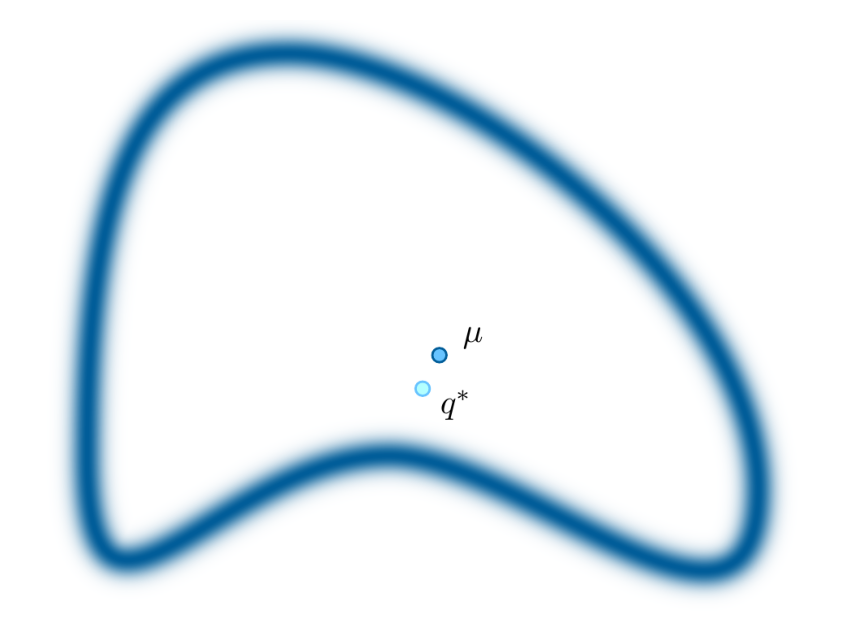

In [157]:
input_file = 'typical_set_with_good_mode.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

### Issues
- skewed distributions have maxima far from expectations
- problems with uncertainty quantisation

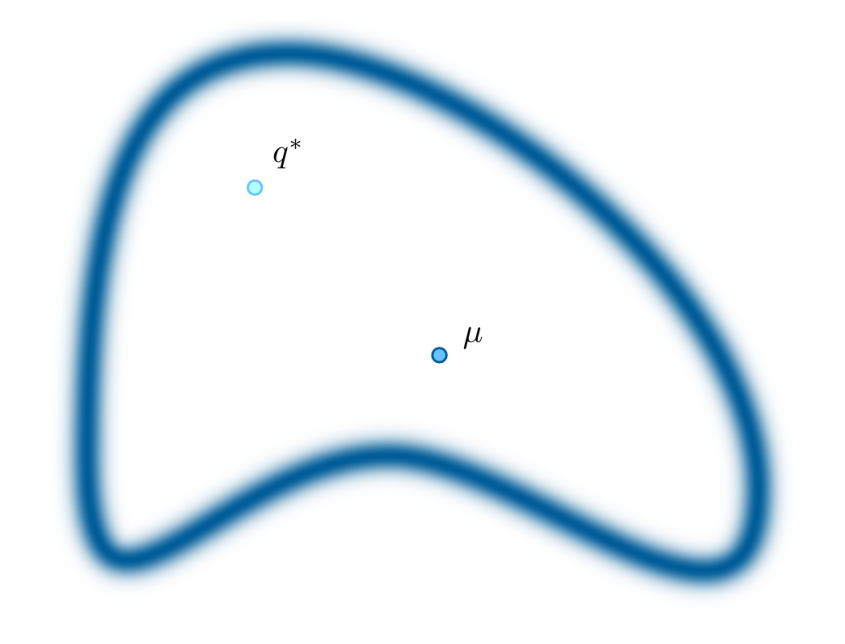

In [158]:
input_file = 'typical_set_with_bad_mode.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


### Laplace estimator

Main idea is to find the maximal value, and fit a Gaussian distribution with a mean in it, and covariance obtained by second order Taylor approximation.

Expectation values can then estimated with Gaussian integrals,
$$
\mathbb{E}_{\pi} \! \left[ f \right]
\approx 
\int_{Q} \mathrm{Normal} \left( q \mid \mu, \Sigma \right) f \left( q \right) \mathrm{d} q 
$$

## If distribution is relatively close to Gaussian, typical set is well approximated

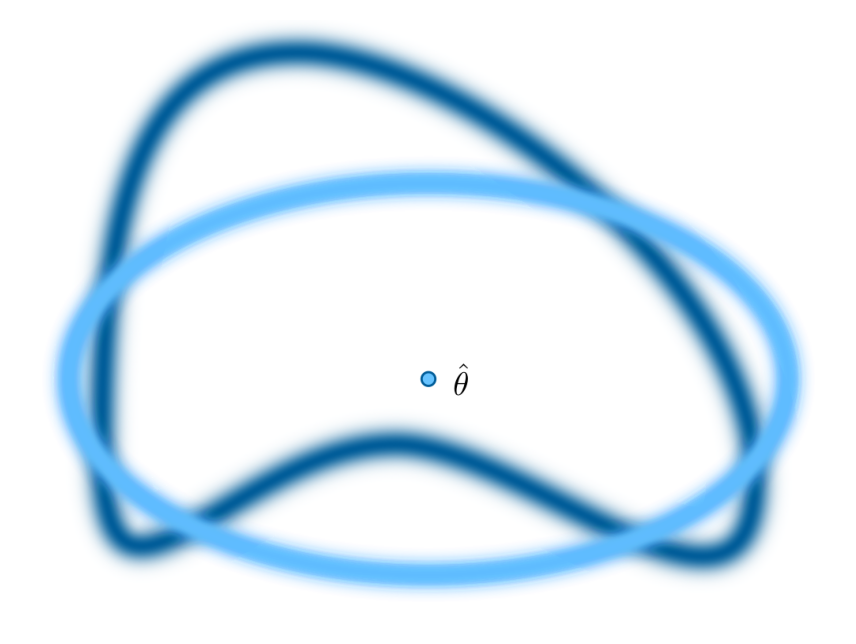

In [159]:
input_file = 'typical_set_with_elipse_2.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300,use_pdftocairo=True)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')
plt.show()

## How to compute expectations?

Analytic integration is practically impossible. 

We are left with quadratures, for ex. Euler
$$
\mathbb{E}_{\pi}[f] \approx 
\sum_{n = 1}^{N} (\Delta q)_{n} \, \pi(q_{n}) \, f(q_{n}).
$$


## Do grid approximations generalize?
It depends

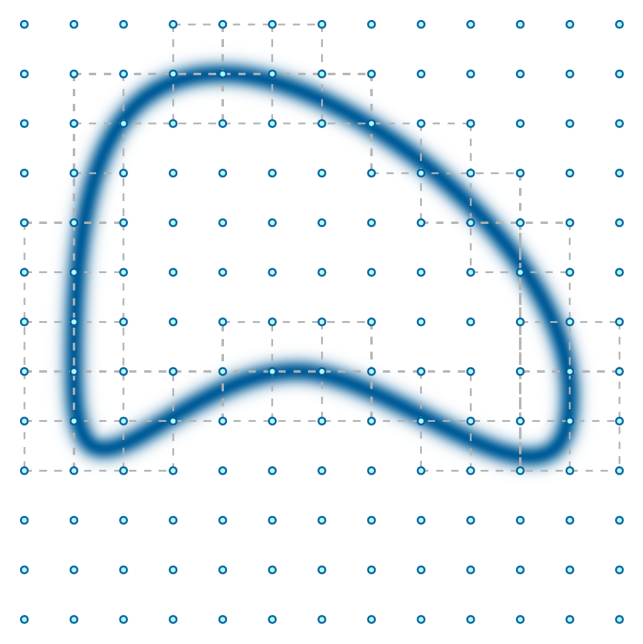

In [160]:
input_file = '2d_grid.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Sometimes geometry is difficult

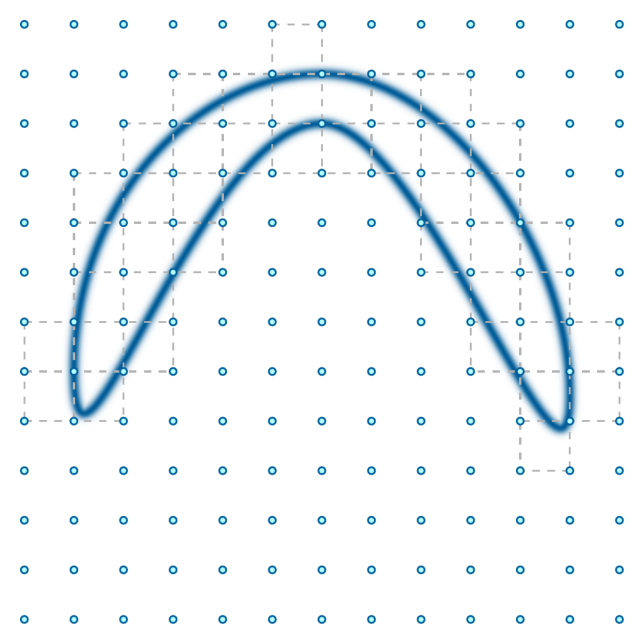

In [161]:
input_file = '2d_grid_finer.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## What contributes to expectation?
Expectation is an integral

$$
\mathbb{E}_{\pi}\![f] = \int_{Q}  \pi(q) \, f(q)\ \mathrm{d} q
$$

Intuitively, wherever distribution $\pi(q)$ is large, it should contribute the most, in particular next to maximum (mode).

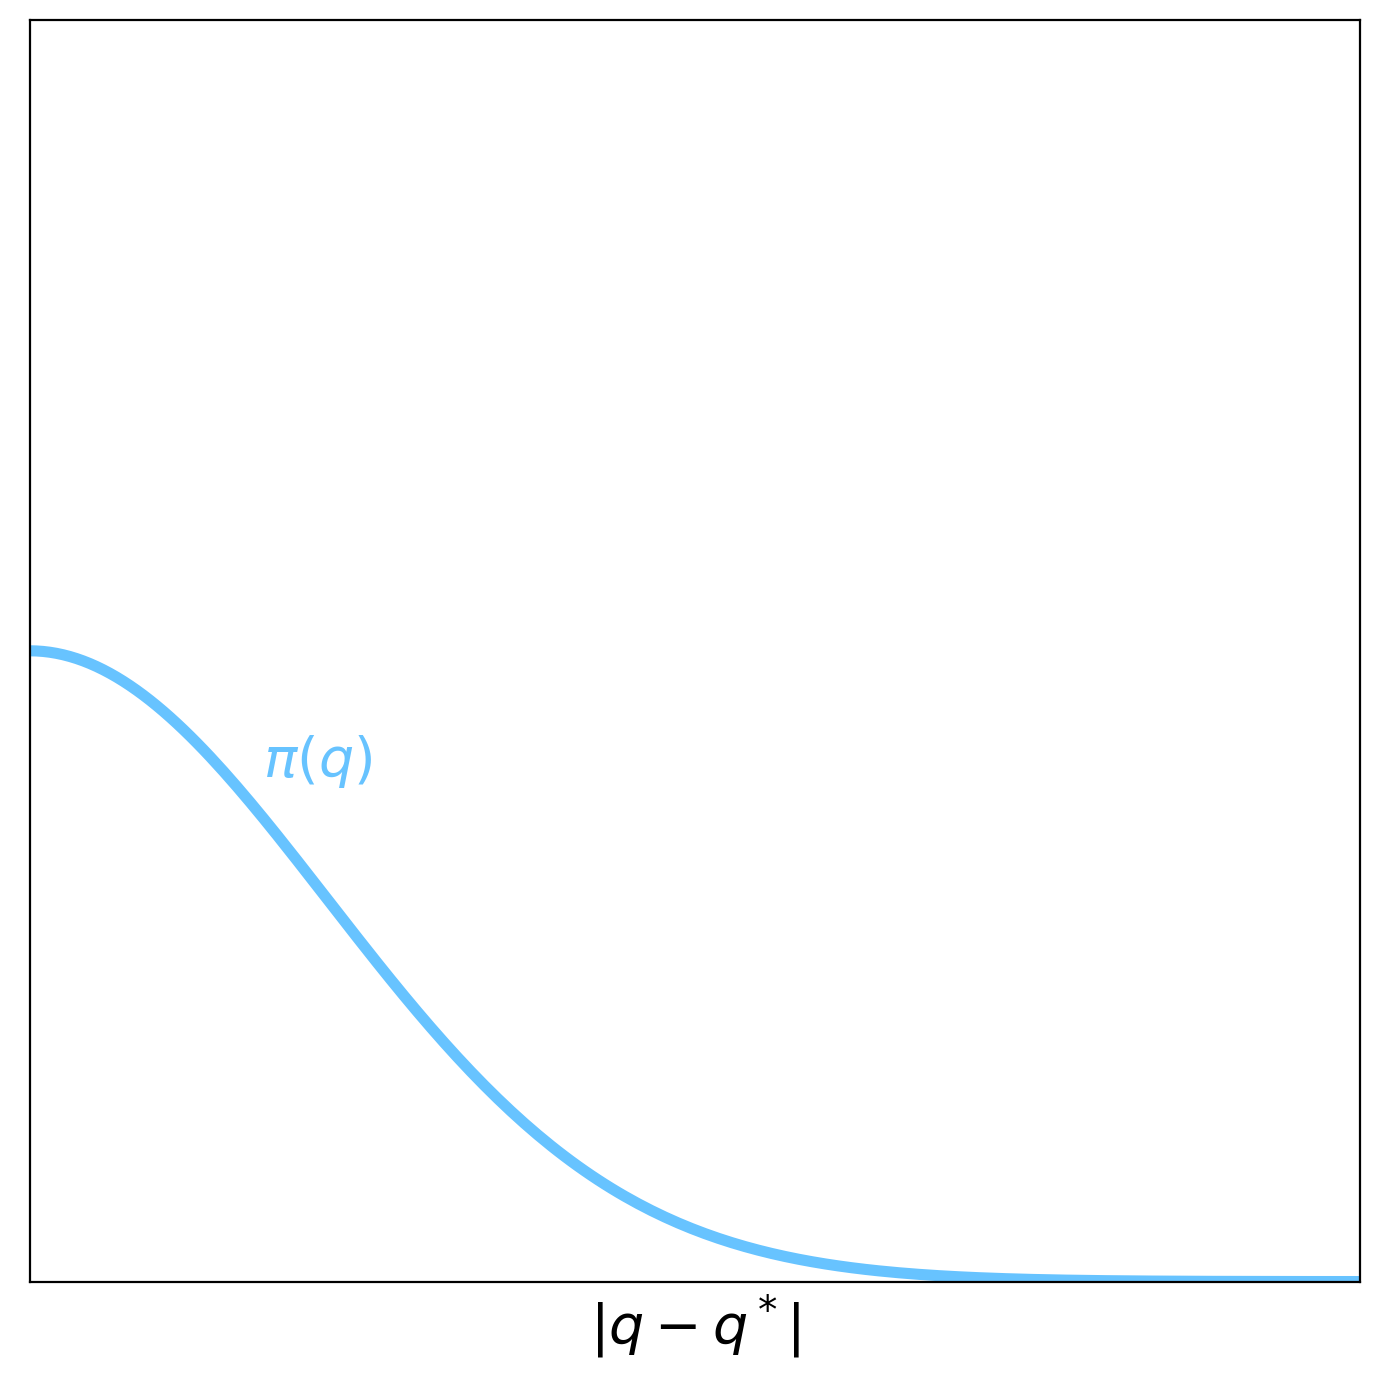

In [162]:
from scipy.special import loggamma 
import matplotlib.patheffects as pe


fig, ax = plt.subplots(1,1, figsize=(7,7), tight_layout=True)
x = np.linspace(0,2,200)
ax.plot(x, np.exp(-0.5*x**2/0.2),c=MID,linewidth=4)
ax.text(0.35,0.8,r'$\pi(q)$', c=MID, fontsize=20)#,path_effects=[pe.withStroke(linewidth=.2, foreground='black')])


ax.set_ylim(0,2)
ax.set_xlim(0,2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel(r'$|q-q^*$|',fontsize = 20)
plt.show()
fig.savefig('../markdown/img/com_distribution.png')

## But what about the volume?

$dq$ is also under the integral, and volume rises with dimension


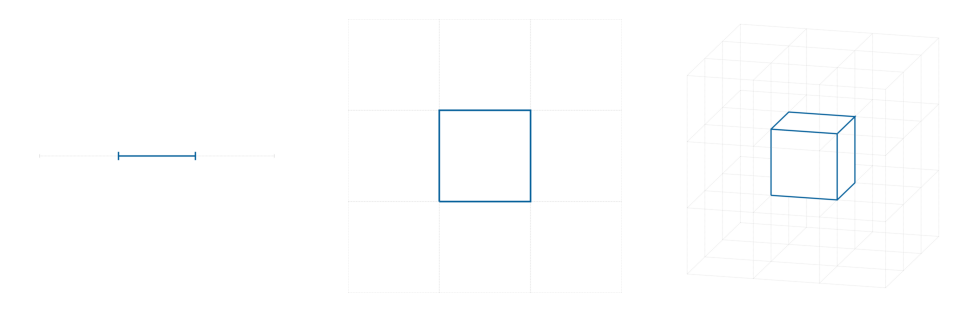

In [163]:
pliki=['line','square','cube']
fig,ax = plt.subplots(1,3)
for k in range(3):
    input_file = '{}.pdf'.format(pliki[k])
    pic_grid = convert_from_path('../tikz/'+input_file,dpi=300,use_pdftocairo=True) 
    output_folder='../markdown/img/'
    output_file=input_file.replace('.pdf','.png')
    pic_grid[0].save(output_folder+output_file, 'PNG')
    ax[k].imshow(pic_grid[0])
    ax[k].set_axis_off()
plt.show()

## Volume rises exponentially with dimension

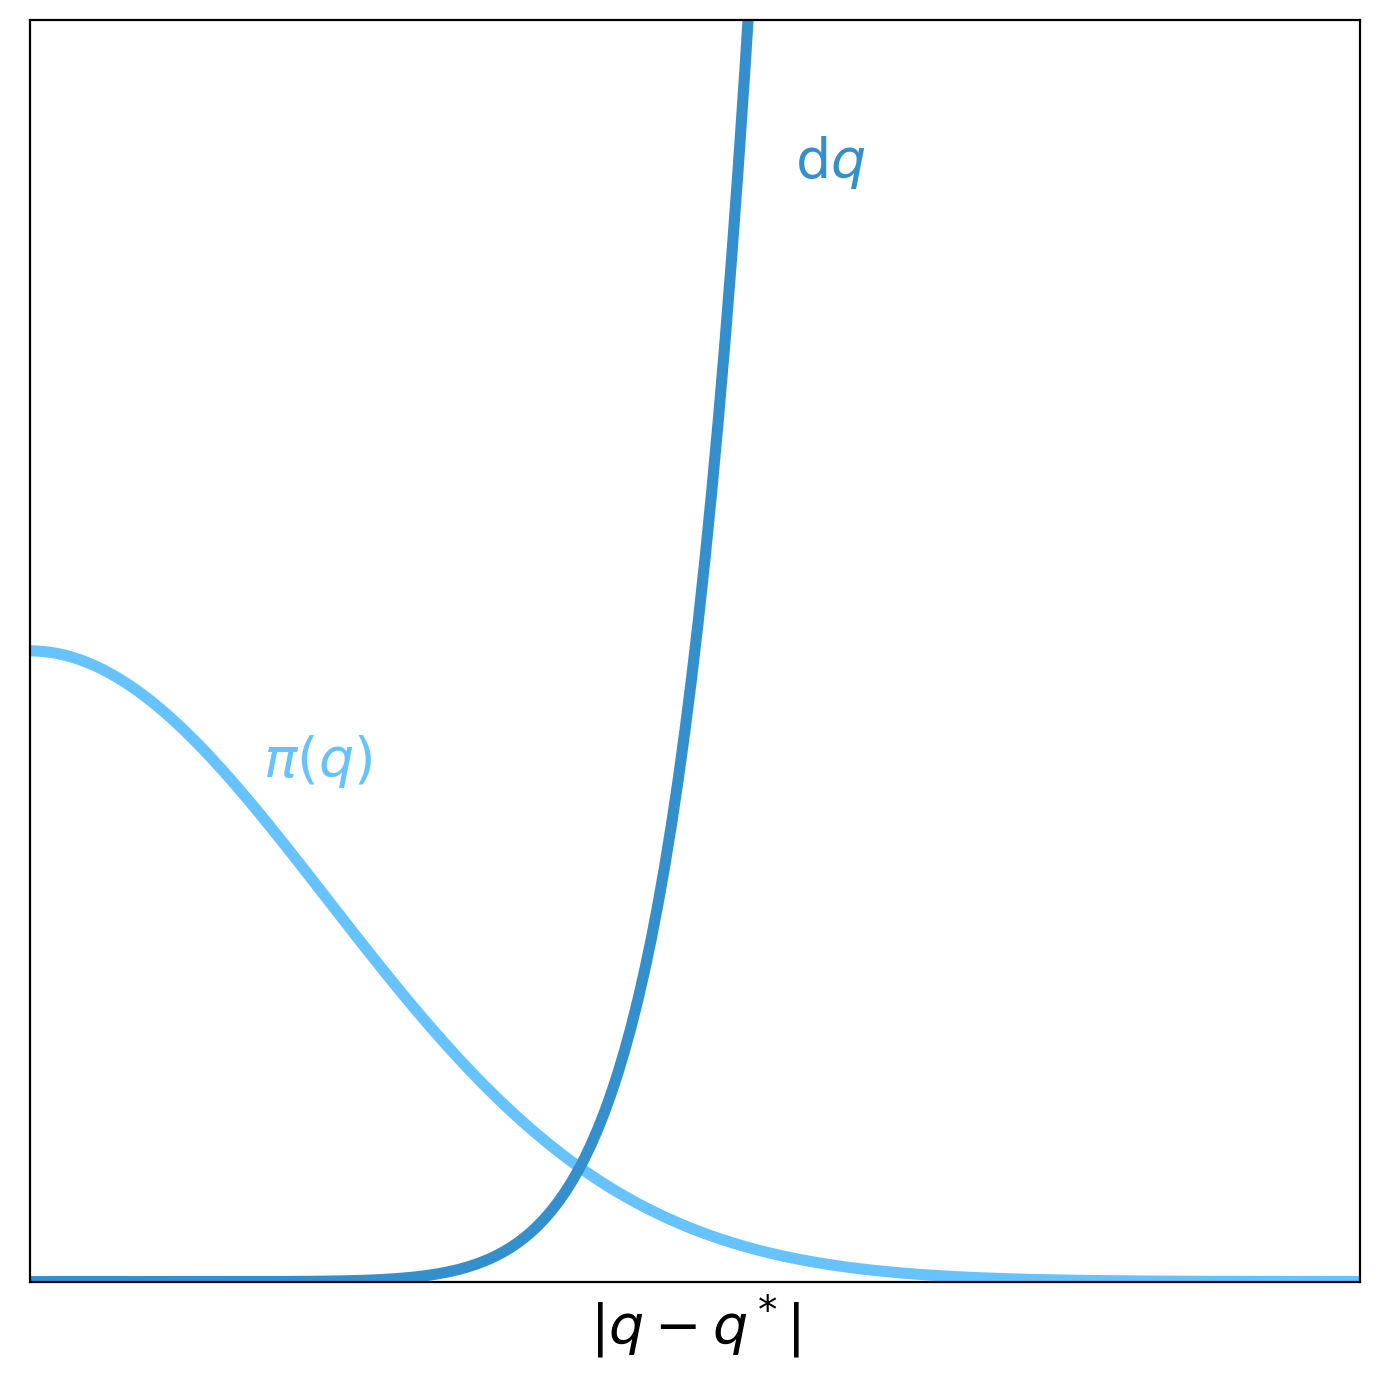

In [164]:
fig, ax = plt.subplots(1,1, figsize=(7,7), tight_layout=True)
x = np.linspace(0,2,200)
ax.plot(x, np.exp(-0.5*x**2/0.2),c=MID,linewidth=4)
ax.text(0.35,0.8,r'$\pi(q)$', c=MID, fontsize=20)#,path_effects=[pe.withStroke(linewidth=.2, foreground='black')])

ax.plot(x, x**9,c=MID_HIGHLIGHT,linewidth=4)
ax.text(1.15,1.75,r'$\mathrm{d}q$', c=MID_HIGHLIGHT, fontsize=20)
fun = lambda x: np.exp(np.log(2.)-loggamma(4.5) - 4.5 * np.log(2.0 * 0.1) + (9) * np.log(x) - 0.5 * x * x / 0.1 )  


ax.set_ylim(0,2)
ax.set_xlim(0,2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel(r'$|q-q^*$|',fontsize = 20)
plt.show()

fig.savefig('../markdown/img/com_volume.png')

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## It is the product that counts


/var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/ipykernel_34710/136924796.py:8: RuntimeWarning: divide by zero encountered in log
  fun = lambda x: np.exp(np.log(2.)-loggamma(4.5) - 4.5 * np.log(2.0 * 0.1) + (9) * np.log(x) - 0.5 * x * x / 0.1 )


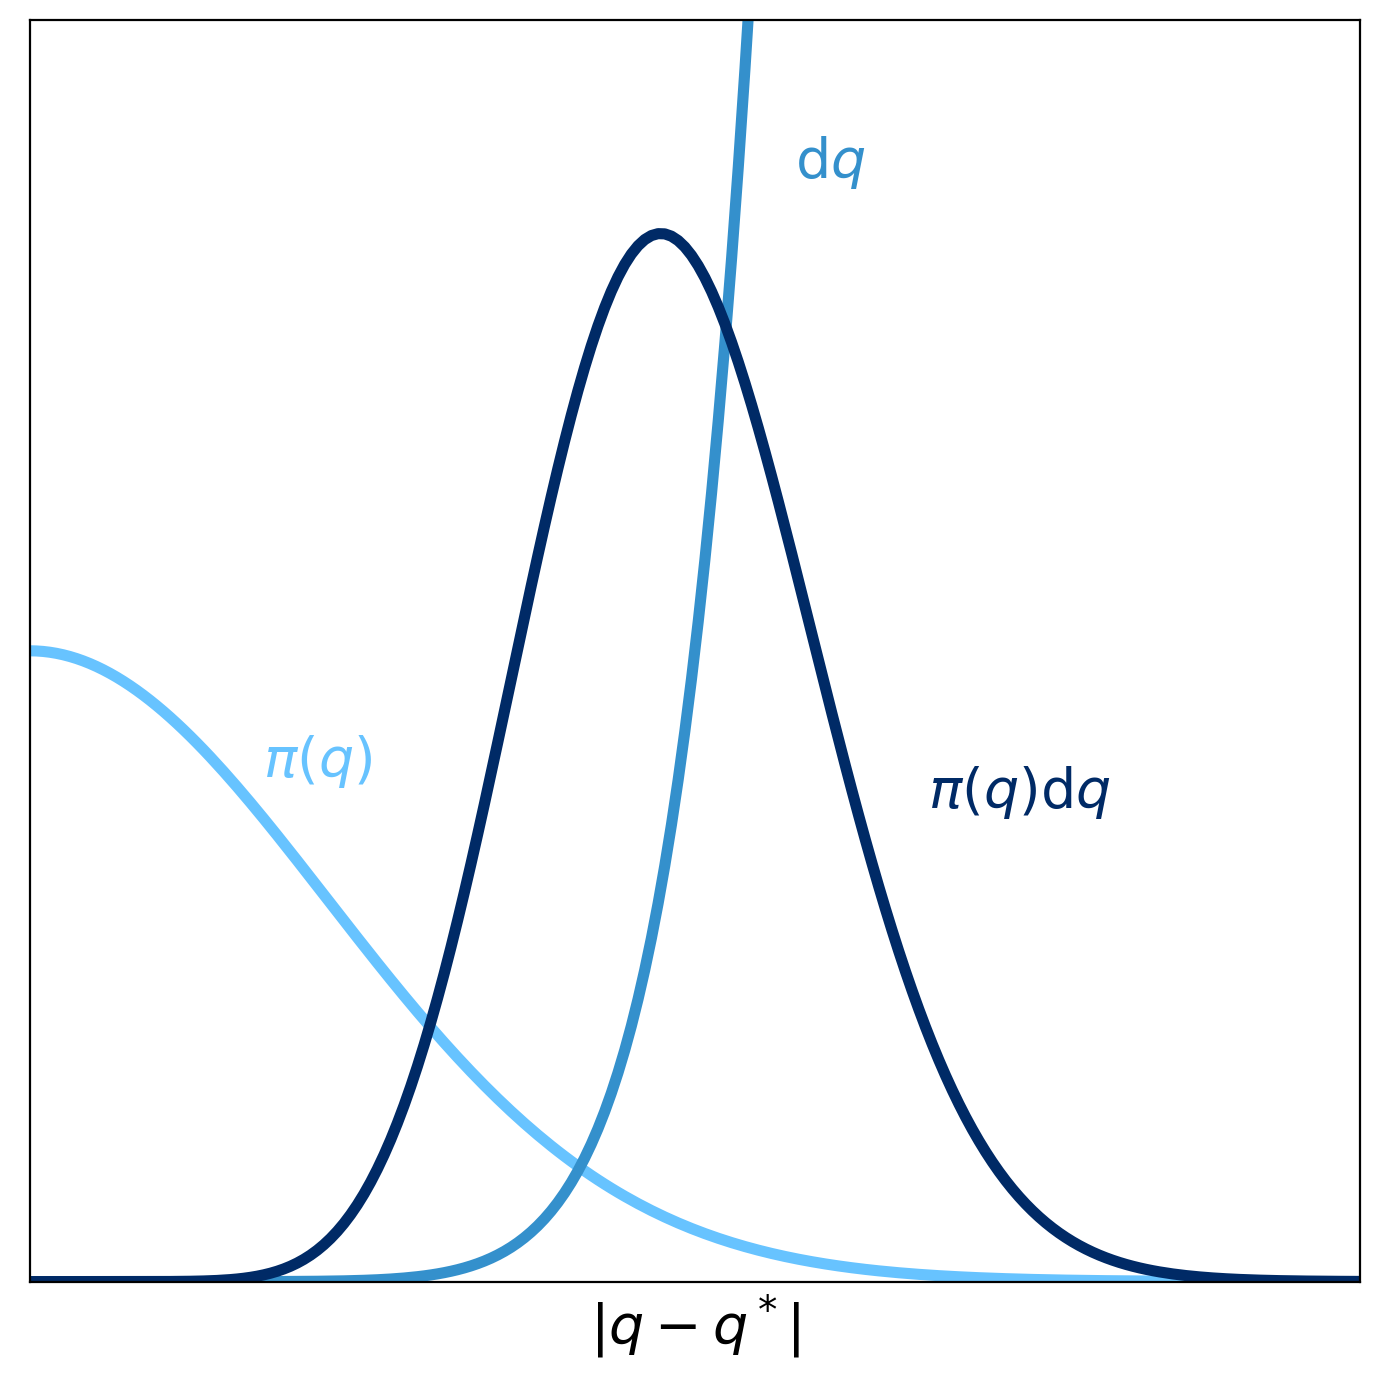

In [165]:
fig, ax = plt.subplots(1,1, figsize=(7,7), tight_layout=True)
x = np.linspace(0,2,200)
ax.plot(x, np.exp(-0.5*x**2/0.2),c=MID,linewidth=4)
ax.text(0.35,0.8,r'$\pi(q)$', c=MID, fontsize=20)#,path_effects=[pe.withStroke(linewidth=.2, foreground='black')])

ax.plot(x, x**9,c=MID_HIGHLIGHT,linewidth=4)
ax.text(1.15,1.75,r'$\mathrm{d}q$', c=MID_HIGHLIGHT, fontsize=20)
fun = lambda x: np.exp(np.log(2.)-loggamma(4.5) - 4.5 * np.log(2.0 * 0.1) + (9) * np.log(x) - 0.5 * x * x / 0.1 )  
ax.plot(x, fun(x),c=DARK_HIGHLIGHT,linewidth=4)
ax.text(1.35,0.75,r'$\pi(q)\mathrm{d}q$', c=DARK_HIGHLIGHT, fontsize=20)

ax.set_ylim(0,2)
ax.set_xlim(0,2)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel(r'$|q-q^*$|',fontsize = 20)
plt.show()
fig.savefig('../markdown/img/com_product.png')

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Typical set
What contributes the most to the expectation are the values from the typical set

/var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/ipykernel_34710/1052921779.py:4: RuntimeWarning: divide by zero encountered in log
  fun = lambda x: np.exp(np.log(2.)-loggamma(4.5) - 4.5 * np.log(2.0 * 0.1) + (9) * np.log(x) - 0.5 * x * x / 0.1 )


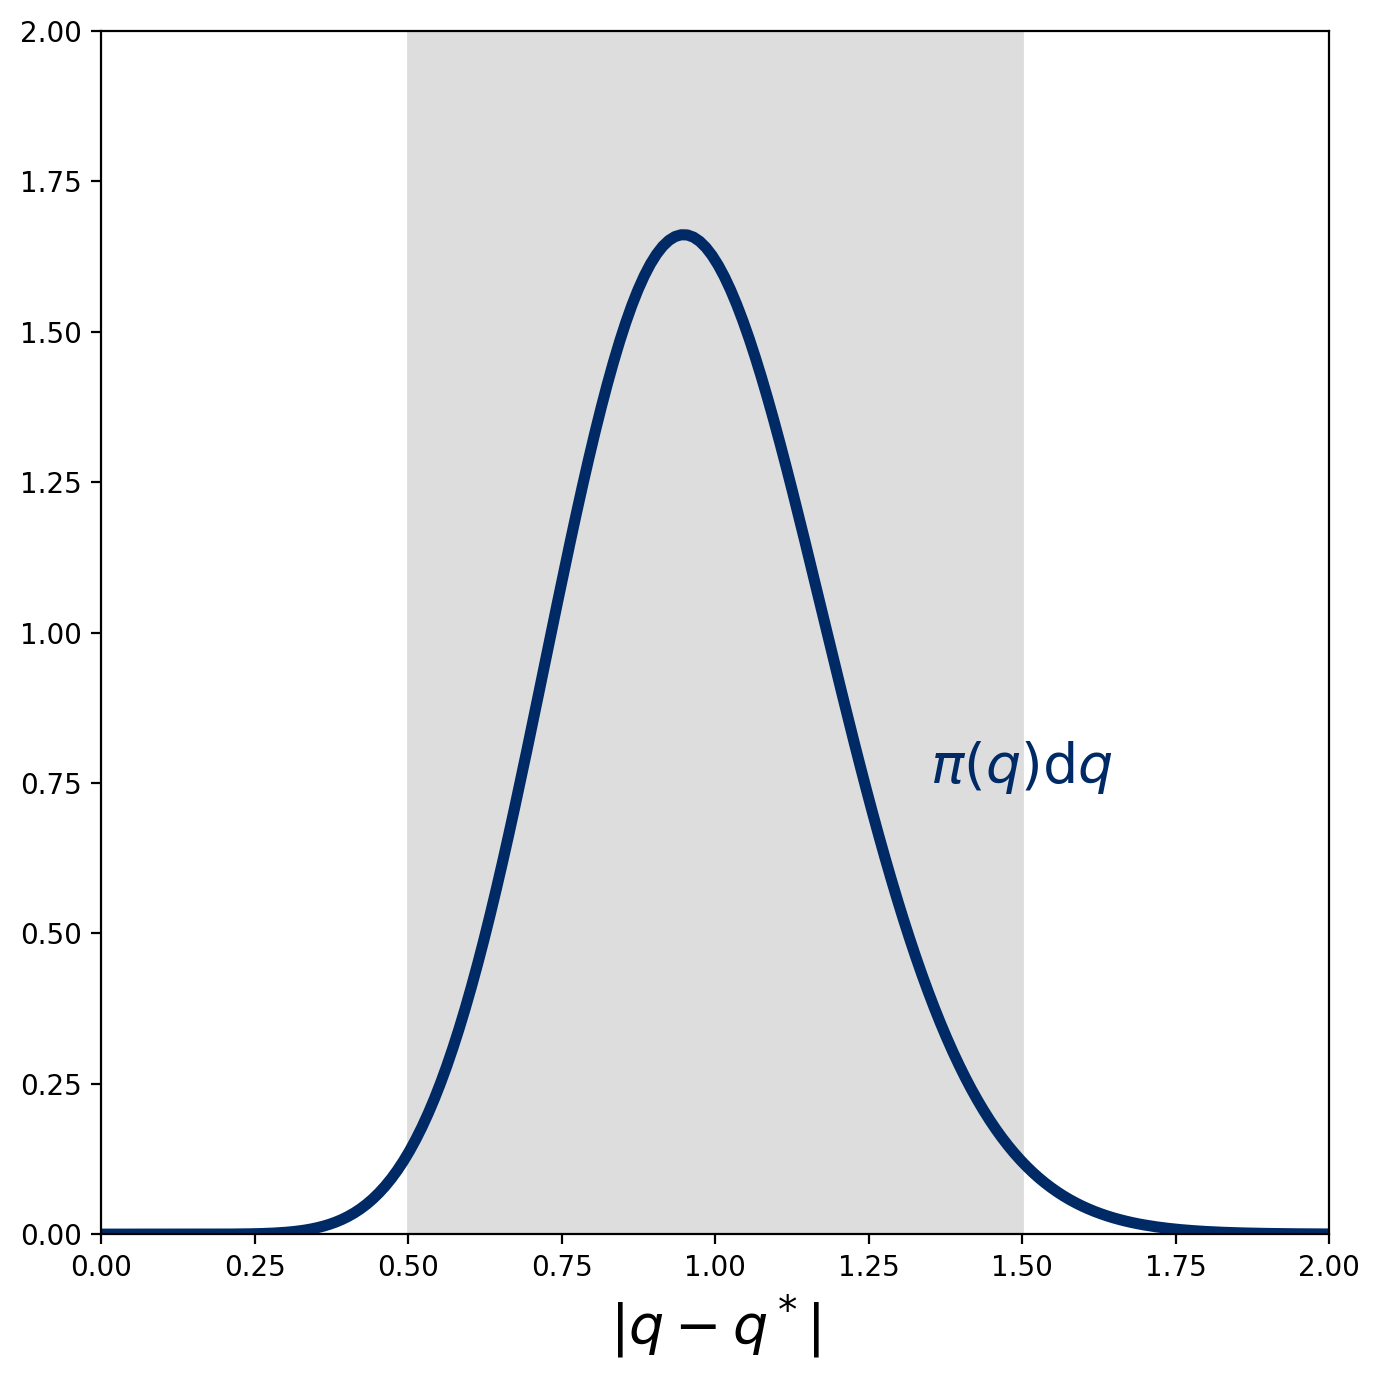

In [166]:
fig, ax = plt.subplots(1,1, figsize=(7,7), tight_layout=True)
x = np.linspace(0,2,200)

fun = lambda x: np.exp(np.log(2.)-loggamma(4.5) - 4.5 * np.log(2.0 * 0.1) + (9) * np.log(x) - 0.5 * x * x / 0.1 )  
ax.plot(x, fun(x),c=DARK_HIGHLIGHT,linewidth=4,zorder=1)
ax.fill_between([0.5,1.5],[0,0],[2,2],color=LIGHT_GREY,zorder=0)
ax.text(1.35,0.75,r'$\pi(q)\mathrm{d}q$', c=DARK_HIGHLIGHT, fontsize=20)



ax.set_ylim(0,2)
ax.set_xlim(0,2)
#ax.set_yticks([])
#ax.set_xticks([])
ax.set_xlabel(r'$|q-q^*$|',fontsize = 20)
plt.show()
fig.savefig('../markdown/img/com_typical_set.png')

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Concentration of measure

Typical set, is a "fuzzy surface" that is located progressively away from the mode with the rise of dimension.

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


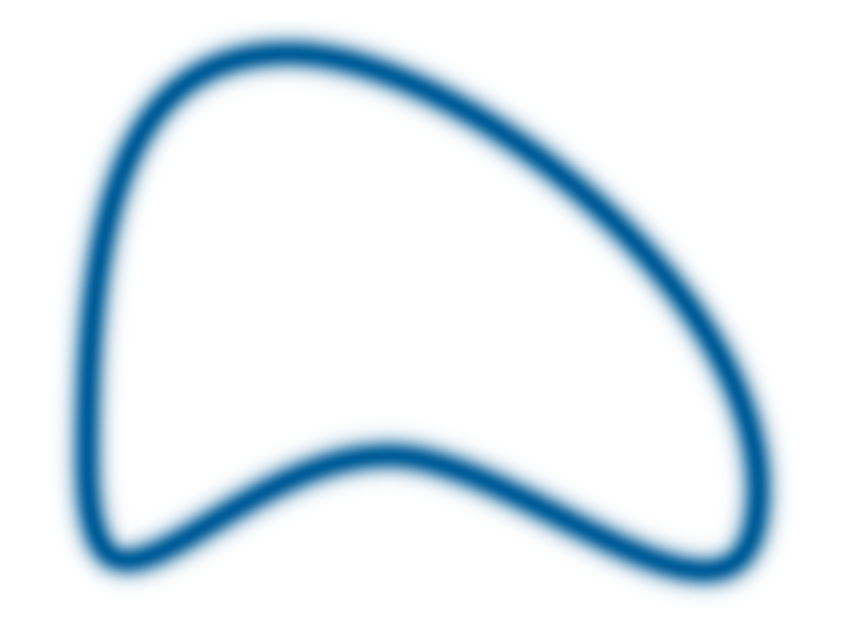

In [167]:
input_file = 'typical_set.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

## Typical set is where we should sample from

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


In [168]:
from svgpathtools import Path, Line, CubicBezier, wsvg

#(-10, -2) .. controls (-10, 5) and (-9, 10) .. (-4, 10)
                # (-10, -2) .. controls (-10, 5) and (-9, 10) .. (-4, 10)
                # .. controls (1, 10) and (10, 3) .. (10, -3)
                # .. controls (10, -9) and (3, -2) .. (-1, -2)
                # .. controls (-6, -2) and (-10, -9) .. (-10, -2);



bezier_curve1 = CubicBezier(start=(-10+-2j), control1=(-10+5j), control2=(-9+10j), end=(-4+10j))
bezier_curve2 = CubicBezier(start=(-4+10j), control1=(1+10j), control2=(10+3j), end=(10-3j))
bezier_curve3 = CubicBezier(start=(10-3j), control1=(10-9j), control2=(3-2j), end=(-1+-2j))
bezier_curve4 = CubicBezier(start=(-1+-2j), control1=(-6-2j), control2=(-10-9j), end=(-10-2j))


bezier_path = Path(bezier_curve1,bezier_curve2,bezier_curve3,bezier_curve4)

NUM_SAMPLES = 40

myPath = []
for i in range(NUM_SAMPLES):
    myPath.append(bezier_path.point(i/(float(NUM_SAMPLES)-1)))



In [234]:
def convert_to_tikz_points(tuple):
    return '\\fill[color=dark] ({0:1.2f}, {1:1.2f}) circle (7pt);\n\\fill[color=light] ({0:1.2f}, {1:1.2f}) circle (5pt);\n'.format(tuple[0],tuple[1])


In [170]:
np.random.seed(42)

with open('../tikz/ts_samples.tex', 'w') as f:
    for c in myPath:
        tuple = (c.real+np.random.normal(scale=0.3), c.imag+np.random.normal(scale=0.3))
        f.write(convert_to_tikz_points(tuple))




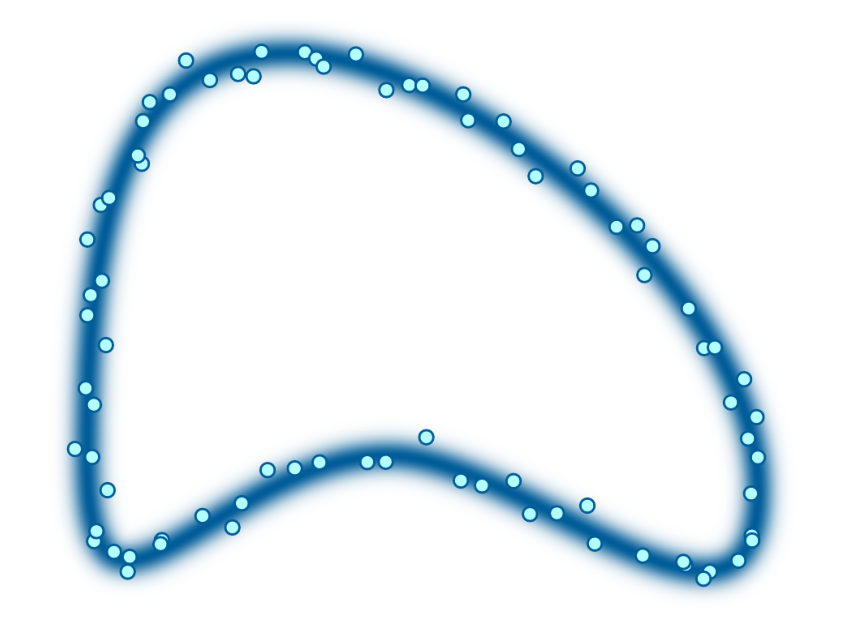

In [171]:
input_file = 'typical_set_samples.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

# How to compute expectations?

Other option is exact sampling, leading to so called Monte Carlo estimators.

If we can generate set of samples $\{ q_{1}, \ldots, q_{N} \} \in Q$, such that

$$\hat{f}_{N}^{\text{MC}} = \frac{1}{N} \sum_{n = 1}^{N} f(q_{n})$$

asymptotically converges

$$
\lim_{N \rightarrow \infty} \hat{f}_{N}^{\text{MC}} = \mathbb{E}_{\pi}[f]
$$

Then we have an exact sampling procedure


## Monte Carlo estimators

Provided, that samples are generated properly we can quantify estimator error

$$
\frac{ \hat{f}_{N}^{\text{MC}} - \mathbb{E}_{\pi}\![f] }
{\text{MC-SE}_{N}[f] } 
\sim \mathcal{N}(0, 1)
$$

With Monte Carlo Standard Error given by
$$
\text{MC-SE}_{N}\![f] 
= \sqrt{ \frac{ \text{Var}_{\pi}\![f]}{N} }
$$

## Monte Carlo estimators



Assuming that we have a sequence of samples from the distribution $\pi$:
$$
\{q_1,\ \ldots,\ q_N\}
$$
for any real valued, integrable function $f$, there exists a Monte Carlo estimator

$$
\hat{f}^{MC}_N = \frac{1}{N} \sum_{n=1}^{N}f(q_n)
$$
is asymptotically consistent, i.e.

$$
\lim_{N\rightarrow\infty}\hat{f}^{MC}_N = \mathbb{E}_\pi[f]
$$

## $\hat{f}^{MC}_N$ is approximately normaly distributed

$$
\hat{f}^{MC}_N \sim \mathrm{normal}\left(y\left|\mathbb{E}_\pi[f], \sqrt{\frac{\mathbb{V}_\pi[f]}{N}}\right.\right)+{O}\left(N^{-\frac{3}{2}}\right)
$$

Higher order terms can usually be considered negligible for $N>10$, and then we can approximate $\mathbb{E}_\pi[f]$ with the probabilistic standard error

$$
\mathrm{MC\text{-}SE}[f]=\sqrt{\frac{\mathbb{V}_\pi[f]}{N}}
$$



## Absolute and relative error

$\text{MC-SE}[f]$ is a measure of absolute error, and can be estimated from the sample as:

$$
\widehat{\text{MC-SE}}[f] = \sqrt{\frac{1}{N} \hat{V}[f]}= \sqrt{\frac{1}{N}\frac{1}{N-1}\sum_{n=1}^N \left(f(x_n)-\hat{\mu}[f]\right)^2}
$$

However for small values of expectation, we can often use relative error
$$
\frac{\widehat{\text{MC-SE}}[f]}{\hat{\mu}[f]}
$$

$\hat{\mu}[f]$ and $\hat{V}[f]$ are sample mean and variance.


## Ensuring relative precission

If our goal is to have desired relative error, we have:

$$
\alpha\geq\frac{\widehat{\text{MC-SE}}[f]}{\hat{\mu}[f]}\quad \quad \alpha\geq\sqrt{\frac{\hat{V}[f]}{N\cdot \hat{\mu}[f]^2}}
$$
$$
\alpha^2\geq {\frac{\hat{V}[f]}{N\cdot \hat{\mu}[f]^2}}
$$
$$
N\geq {\frac{\hat{V}[f]}{\alpha^2\cdot \hat{\mu}[f]^2}}
$$



## Sumarizing samples

- Moments and cumulants
- Event probabilities
- Histograms
- ECDFs
- Quantiles

## Moments and cumulants

 - For the purpose of distriution summary multiple functions can be used.
 - The most known are the moments, like mean, variance, skewness, kurtosis
 - Also known are cummulants, which partially overlap moments

## Probabilities

- One of the more usefull quantities of interest is the probability if function value lies in the interval of interest. 
- This is done by computing expectations of indicator functions $\mathbb{I}_{\Delta f}$
$$
\mathbb{I}_{\Delta f}(f(x)) = \begin{cases} 1&\text{for }f(x)\in\Delta f\\
 0&\text{for }f(x)\not\in\Delta f
\end{cases}
$$
- Expectation is estimated as usual, so 
$$
\mathbb{P}_{\pi}[\Delta f] = \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]  \approx \frac{1}{N}\sum_{i=0}^N \mathbb{I}_{\Delta f}(f(x_n))=\frac{N[\Delta f]}{N} = p
$$
which is the proportion of samples laying in the interval

## Probability uncertainity
MC-SE of indicator function is relatively easy to determine, as square of indicator is given by  

$$
\mathbb{I}_{\Delta f}^{2} = \mathbb{I}_{\Delta f}
$$
Then the variance of an indictor function can be computed directly from the
corresponding probability,
$$
\begin{align*}
\mathbb{V}_{\pi}[\mathbb{I}_{\Delta f}]
&=
\mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}^{2}]
- \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]^{2}
\\
&=
\mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]
- \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]^{2}
\\
&=
\mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}] \cdot (1 - \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}] )
\\
&=
\mathbb{P}_{\pi}[\Delta f] \cdot (1 - \mathbb{P}_{\pi}[\Delta f] )
\\
&\equiv
p \cdot (1 - p).
\end{align*}
$$

## Absolute and relative errors
MC-SE as always gives us absolute error
$$
\text{MC-SE}[ \mathbb{I}_{\Delta f} ] = \sqrt{ \frac{p \cdot (1 - p) }{N} }.
$$
relative error however

$$
\begin{align*}
\frac{ \hat{\sigma}[\mathbb{I}_{\Delta f}]  }{ \hat{\mu}[\mathbb{I}_{\Delta f}]  }
&=
\frac{ \sqrt{ \frac{p \cdot (1 - p) }{N} } }{ p }
\\
&=
\sqrt{ \frac{1 - p}{N \cdot p} }
\end{align*}
$$
increases with decreasing estimated probability.

## Small relative error requires lot of samples

For example if $p = 0.01$ and we want a relative error of 5% then we need a
sample size of
$$
N \gt \frac{ 0.99 }{ (0.05)^{2} \cdot 0.01 } = 39600
$$

## Histograms

- Histogram is the task of probability estimation done for the entire space split into intervals. 
- All the above analysis also works here
- Types of normalization:
    - No normalization - just counts
    - Counts divided by number of samples - probability estimates $\approx$ probability mass function
    - Integral equal to 1 

## Empirical Cumulative Distribution Function

In a way companion to a histogram

```python
def ecdf(x):
    N=len(x)
    srt_x = np.sort(x)
    values, counts = np.unique(srt_x, return_counts=True)
    probs = np.cumsum(counts/N)
    return values, probs
```

Uncertainity comes from probability estimate MC-SE for the intervals $I(y_{min}, f(x_n))$

## Quantiles

In a way inverse problem to determining probability of interval. A $p$-quantile is defined
implicitly as the point $y_{p} \in Y$ satisfying

$$
p = \mathbb{P}_{\pi} [ I(y_{\text{min}}, y_{p}) ].
$$

Simple if we have a point, for which $p(f(x_n))=p$, then $y_p = f(x_n)$ otherwise it has to be interpolated between $f(x_n)$ and $f(x_{n+1}$), such that

$$
p(f(x_{n})) \lt p \lt p(f(x_{n + 1}))
$$

Low probability quantiles still require lot of samples to obtain low relative errors.

## Random number generation

In order to get random samples we need to find a way of obtaining 'randomness'

- Hardware random number generators
- Pseudo-random number generators

## Pseudo-random number generators

- a formula for generating a sequence of numbers that preferably
    - has low autocorrelation
    - has a long period
    - uniformly distributes quantiles of generated numbers
- simplest way is a linear congruent recurrence:

$$ X_{n+1}=(a X_n + c)\ \mathrm{mod}\ m $$

- currently widely adapted is the *Meresene twister* algorithm



## Preliminaries
For probability distrubution $\pi$ defined over one-dimensional space $X$, and point $x\in X$ we can define an interval
$$
I(x_{min},x)\subset X
$$ 
which has a probablity $\mathbb{P}_\pi[I(x_{min},x)]$.

The cumulative distribution function (CDF) maps each point to this corresponding
probability

$$
\begin{alignat*}{6}
\Pi :\; &X& &\rightarrow& \; &[0, 1] \subset \mathbb{R}&
\\
&x& &\mapsto& &\mathbb{P}_{\pi}[I(x_{\text{min}}, x )]&
\end{alignat*}
$$

Quantile function, for all intents and purposes is the inverse of CDF
$$
q_\pi(p)=\Pi^{-1}(x)
$$


## Getting from uniform to arbitrary

- In one dimension it is relatively easy.
- PRNG generates a sequence of uniformly distributed numbers $\{p_1,\ldots,p_N\}$ in $[0,1]$ interval
- The sequence $\{q_\pi(p_1),\ldots,q_\pi(p_N)\}$ is a sample from $\pi$ distribution   

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; EA &amp; Bioware </div>


## Grid approximation
1. Define the grid. This means you decide how many points to use in estimating the posterior, and then you make a list of the parameter values on the grid.
2. Compute the value of the prior at each parameter value on the grid.
3. Compute the likelihood at each parameter value.
4. Compute the unstandardized posterior at each parameter value, by multiplying the prior by the likelihood.
5. Finally, standardize the posterior, by dividing each value by the sum of all values.

## Example 1 - normal distribution

We get 1000 samples from $N(1,1.25)$ distribution

```python 
from numpy.random import normal
sample_normal = normal(loc=1,scale=1.25,size=1000)
```



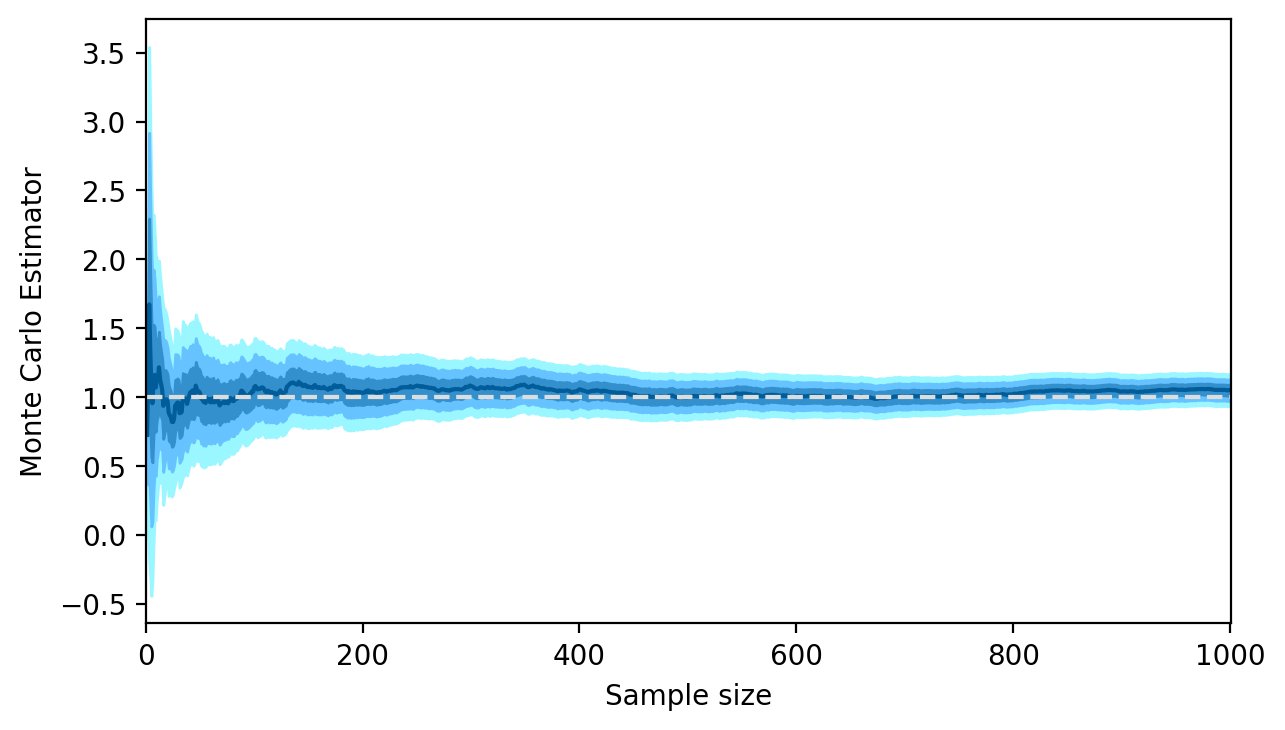

In [172]:
sample_normal = normal(loc=1,scale=1.25,size=1000)
rolling_mean, rolling_mcse = rolling_stats(sample_normal)
fig_rolling_normal,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
ax.plot([1,1000],[1,1],color=LIGHT_GREY,linestyle='--')
plt.show()

fig_rolling_normal.savefig('../markdown/img/fig_rolling_normal.png')

## Estimate uncertainity reduces with increasing sample size

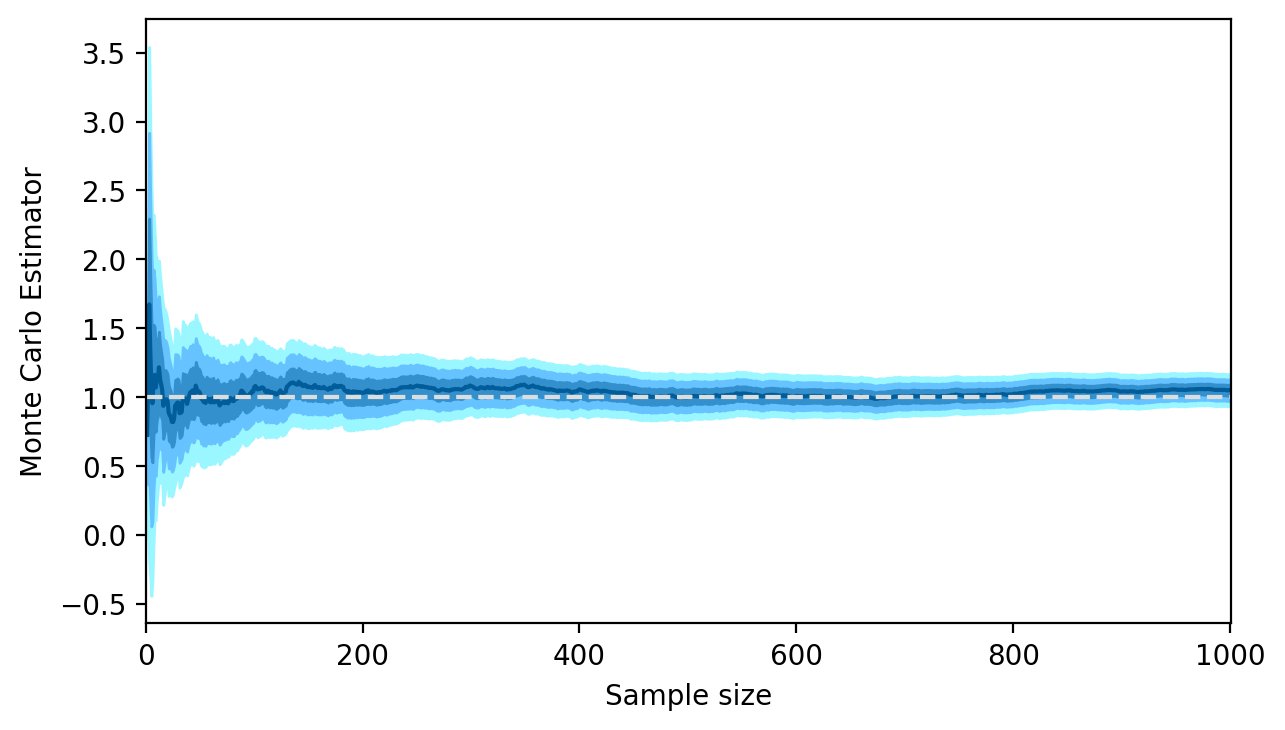

In [173]:
fig_rolling_normal

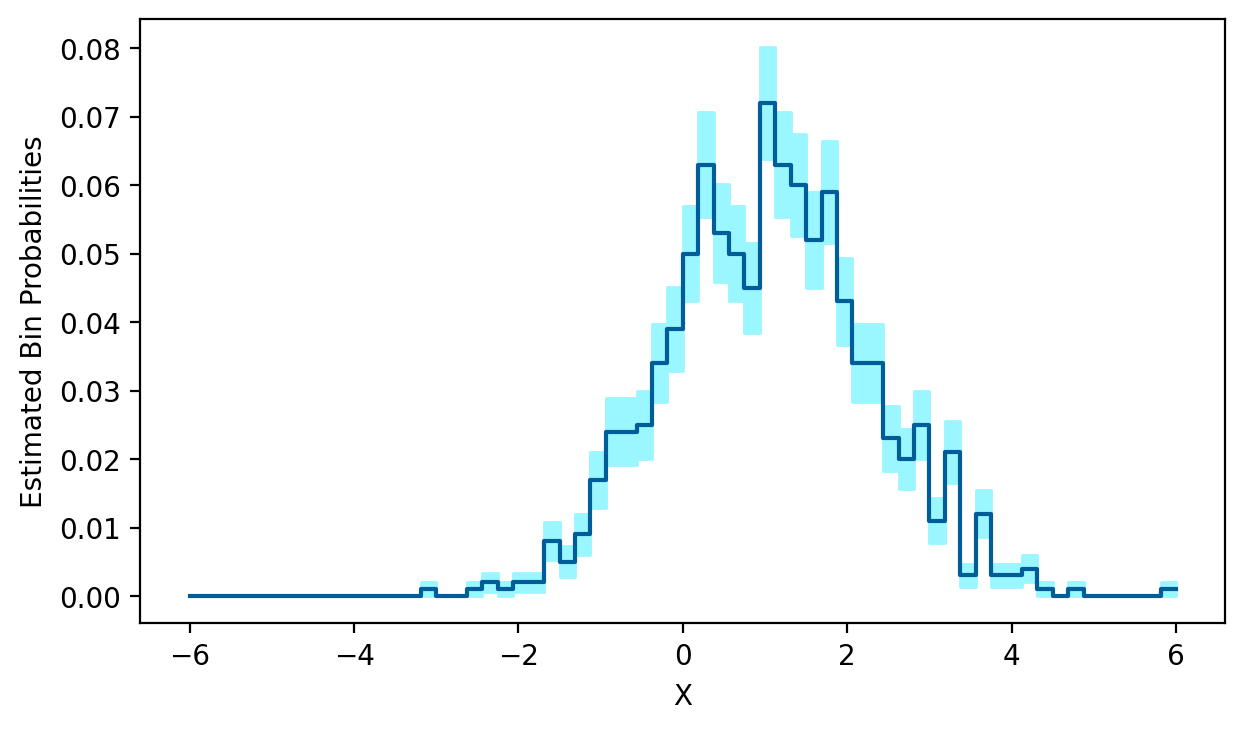

In [174]:
N=len(sample_normal)
bins = np.linspace(-6,6,13*5)
fig_normal_histogram,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(sample_normal,bins)
xs = np.linspace(-6,6,200)
ax=mc_hist_plot(new_bins, probs,mc_se,ax)
fig_normal_histogram.savefig('../markdown/img/fig_normal_histogram.png')

## Histogram of the sample 

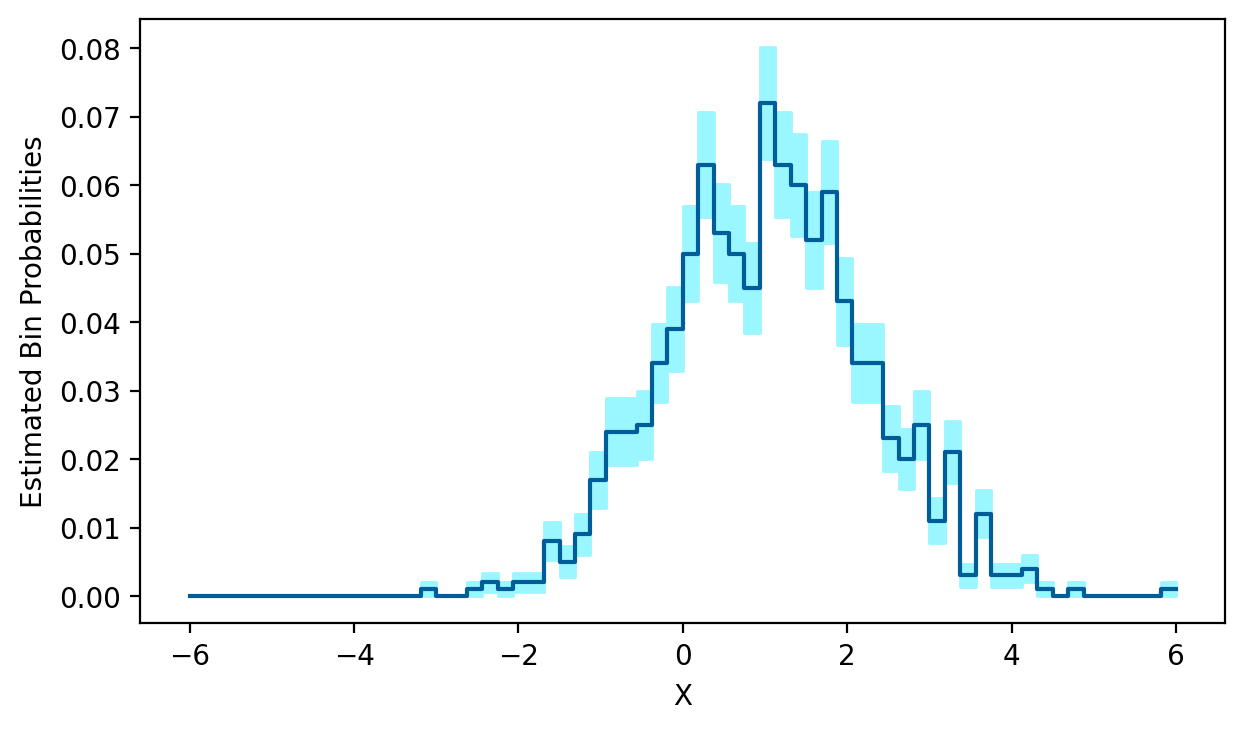

In [175]:
fig_normal_histogram

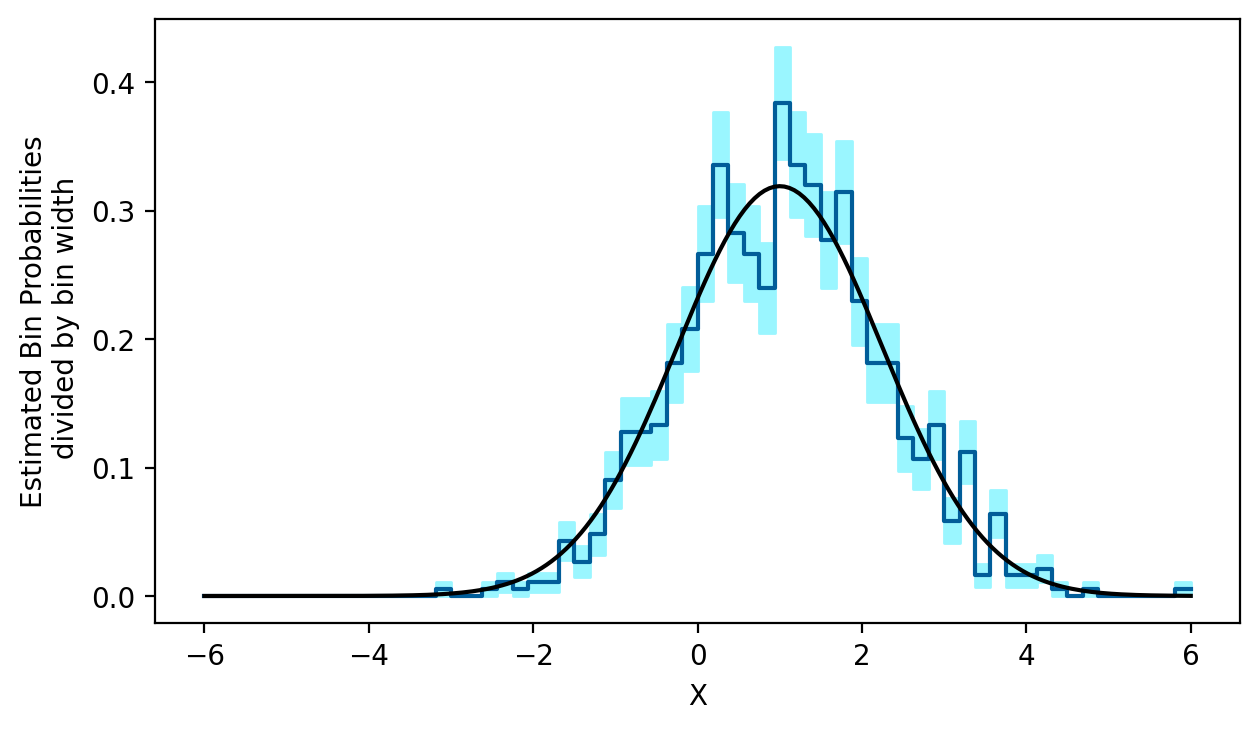

In [176]:
N=len(sample_normal)
bins = np.linspace(-6,6,13*5)
fig_normal_analytical,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(sample_normal,bins)
xs = np.linspace(-6,6,200)
ax=mc_hist_plot(new_bins, probs,mc_se,ax,scale=True)
ax.plot(xs,stats.norm.pdf(xs,1,1.25),color='black')
fig_normal_analytical.savefig('../markdown/img/fig_normal_analytical.png')

## Comparison with analytical result

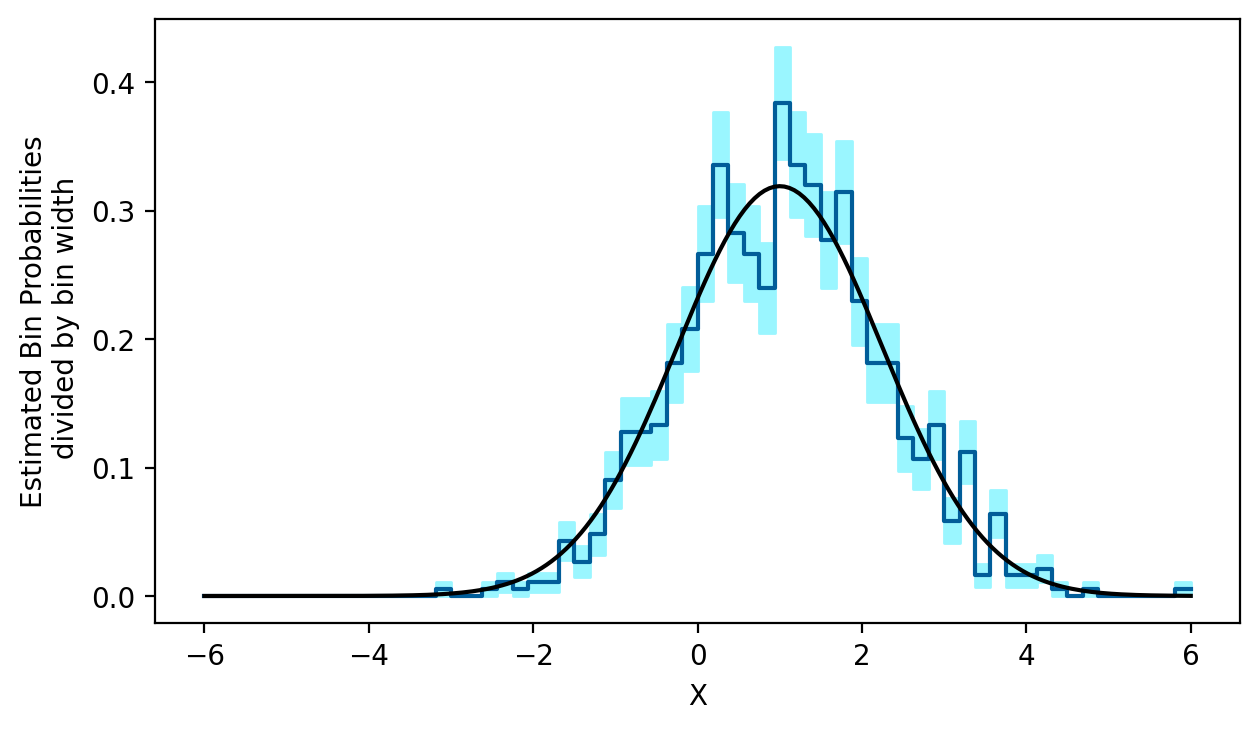

In [177]:
fig_normal_analytical

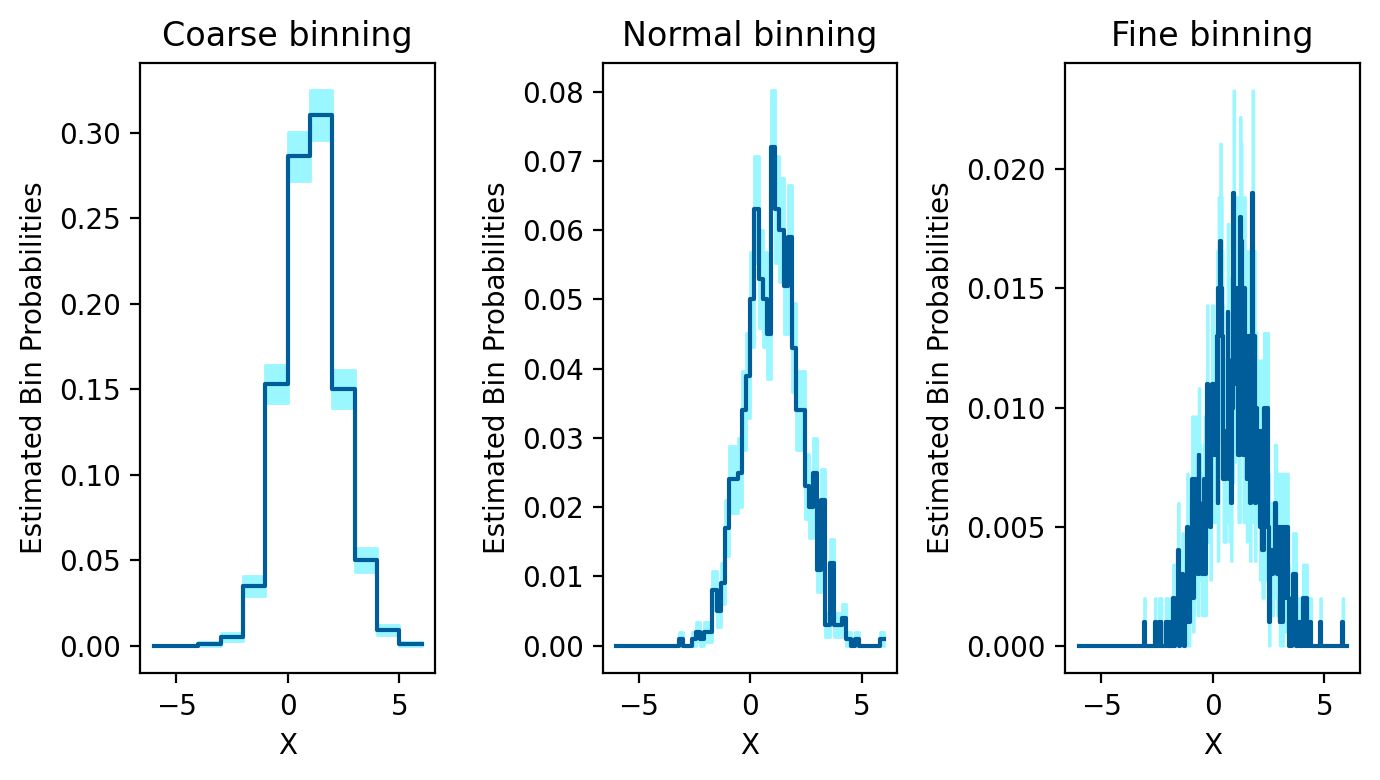

In [178]:
fig_binning,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (7,4),)

new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13))
ax1=mc_hist_plot(new_bins, probs,mc_se,ax1)
ax1.set_title('Coarse binning')
new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13*5))
ax2=mc_hist_plot(new_bins, probs,mc_se,ax2)
ax2.set_title('Normal binning')

new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13*25))
ax3=mc_hist_plot(new_bins, probs,mc_se,ax3)
ax3.set_title('Fine binning')

plt.tight_layout()
fig_binning.savefig('../markdown/img/fig_binning.png')

## Binning makes a difference 

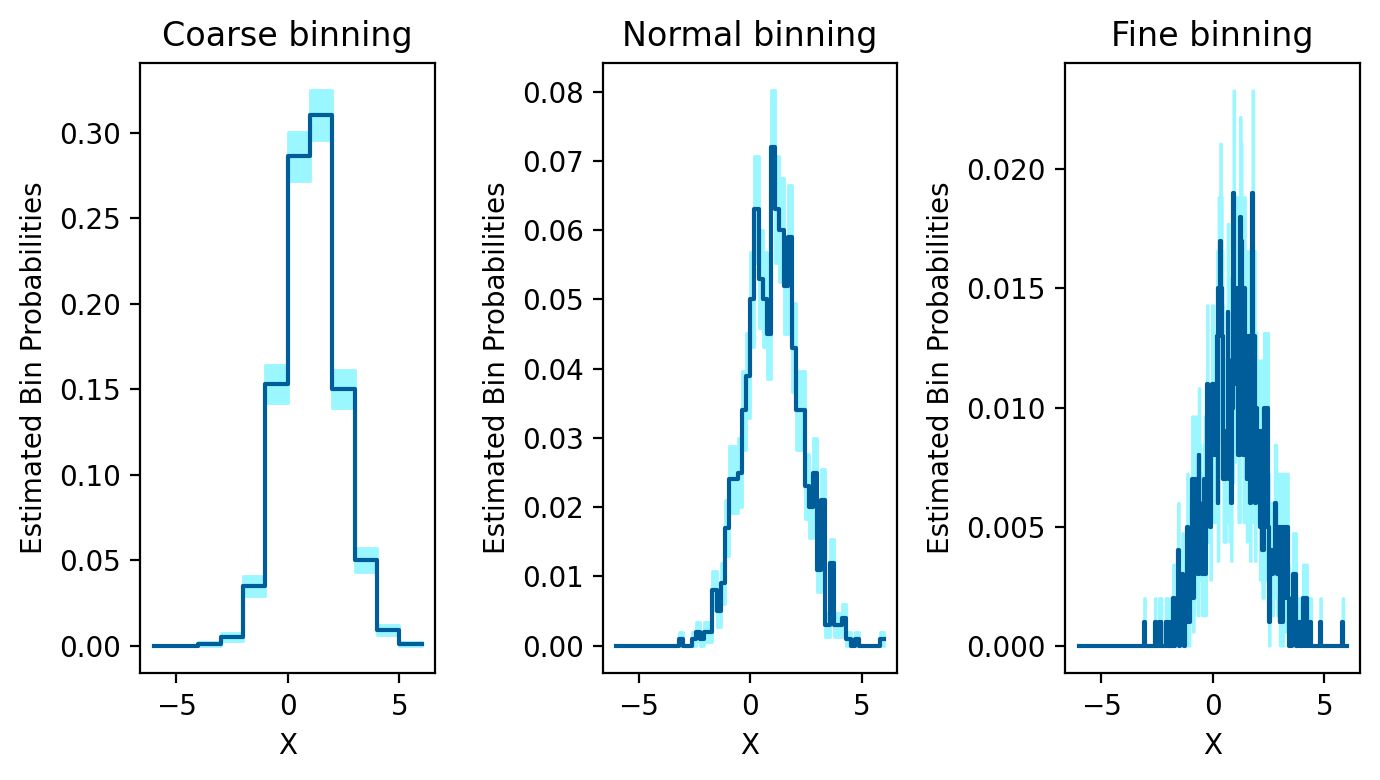

In [179]:
fig_binning

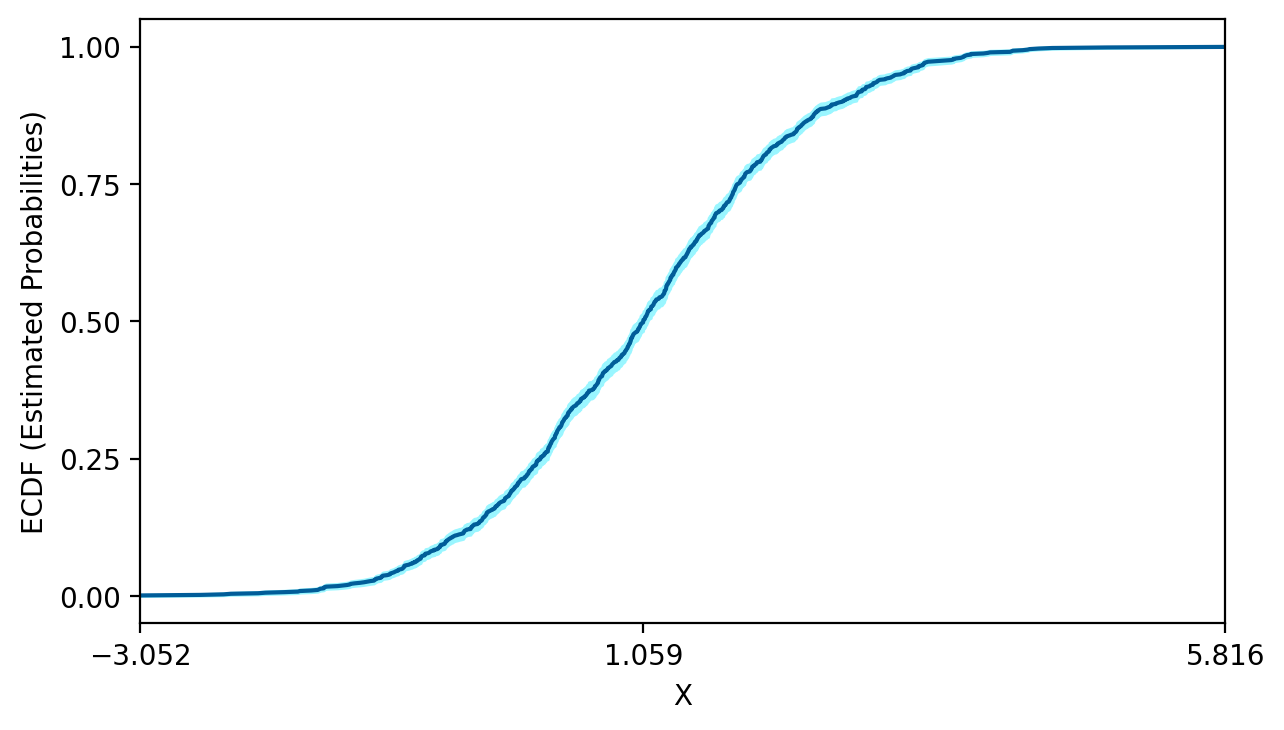

In [180]:
values, probs, mc_se = mc_ecdf(sample_normal)
fig_normal_ecdf,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_ecdf_plot(values, probs, mc_se,ax)
plt.show()
fig_normal_ecdf.savefig('../markdown/img/fig_normal_ecdf.png')

## ECDF

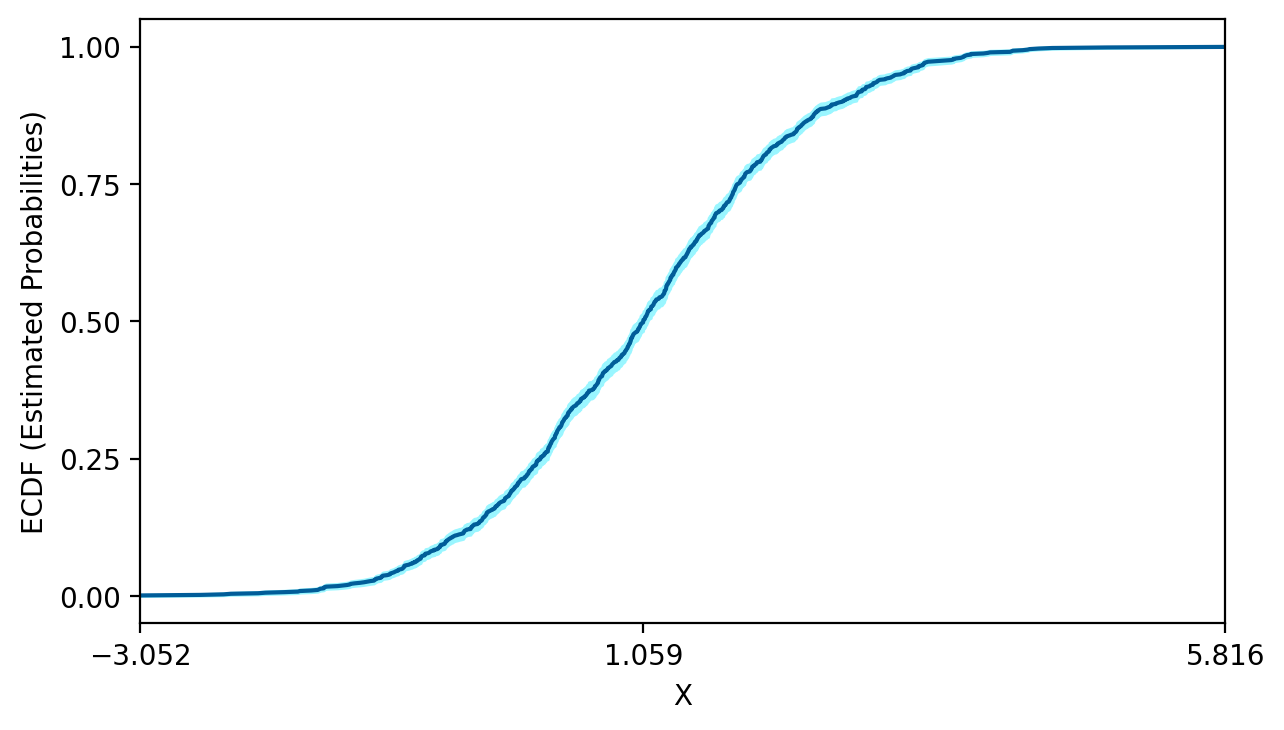

In [181]:
fig_normal_ecdf

## Example 2 - Normal samples pushed through inverse logistic function

Inverse logit (or expit) function 

$$
\begin{alignat*}{6}
\text{logit}^{-1} :\; &X = \mathbb{R} & &\rightarrow& \; &[0, 1] \subset \mathbb{R}&
\\
&x& &\mapsto& &\frac{1}{1 + \exp(-x)}&.
\end{alignat*}
$$

In python it is readilly available

```python
from scipy.special import expit,logit

```


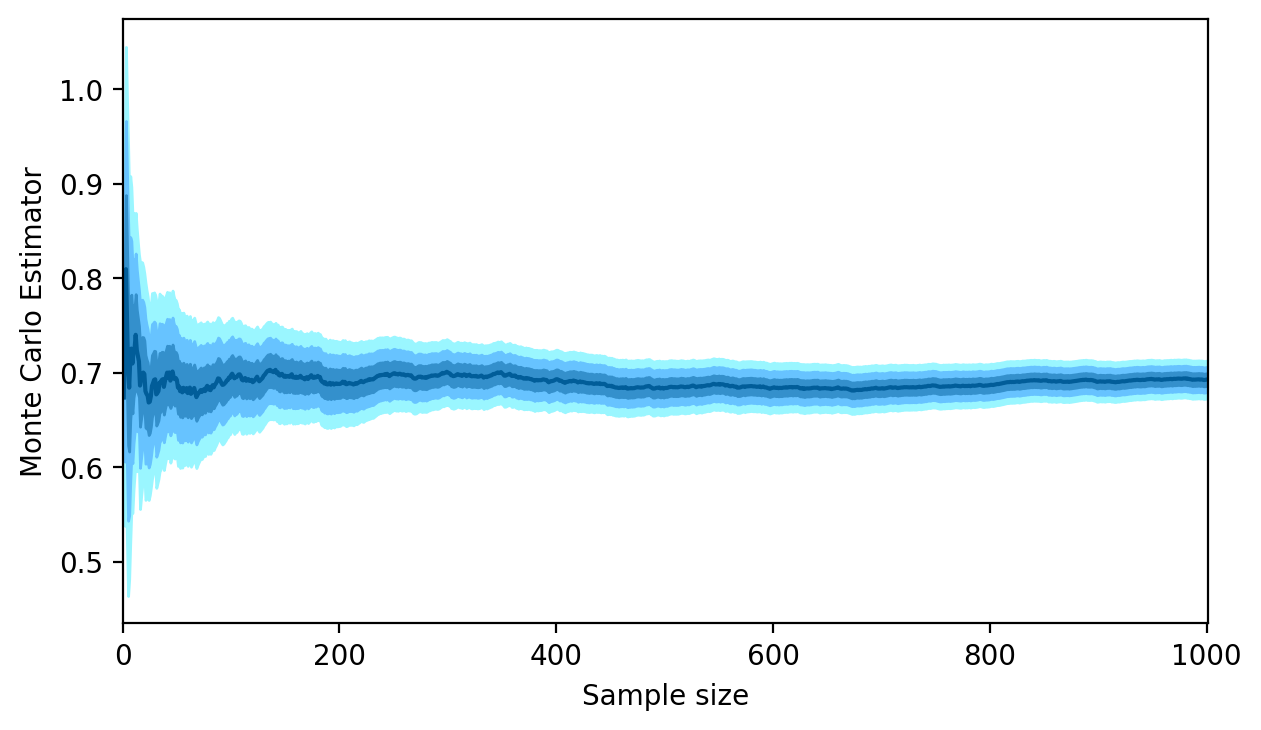

In [182]:
sample_pushforward = expit(sample_normal)
rolling_mean, rolling_mcse = rolling_stats(sample_pushforward)

fig_rolling_logit,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()
fig_rolling_logit.savefig('../markdown/img/fig_rolling_logit.png')

## Samples are constrained, but expecation converges

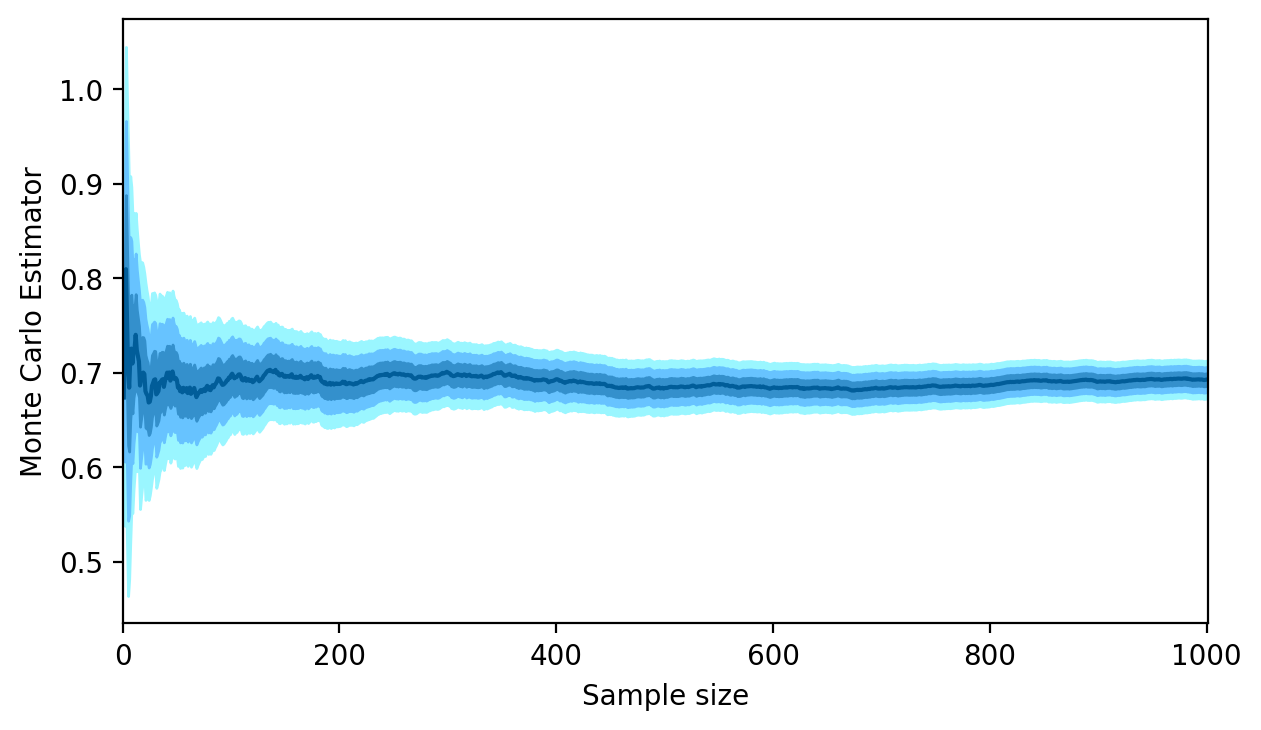

In [183]:
fig_rolling_logit

## Histogram allows observation of concentration around expected value

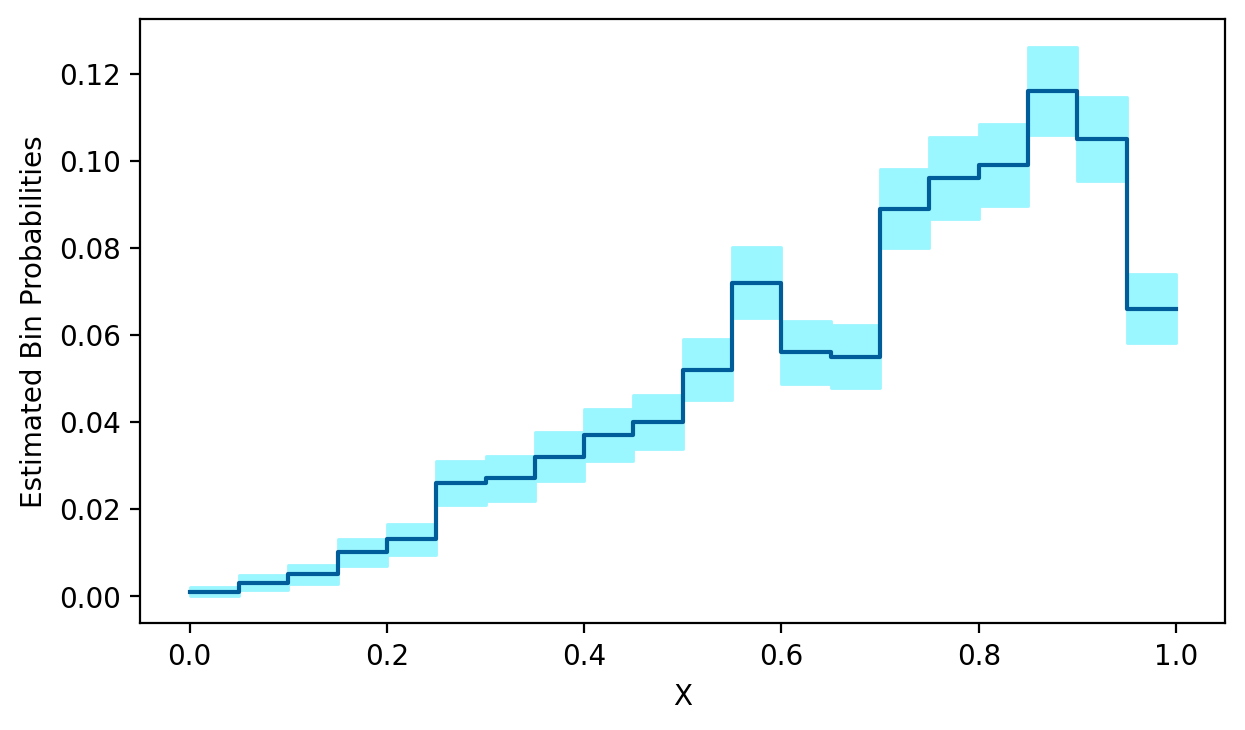

In [184]:
bins = np.linspace(0,1,21)
new_bins, probs,mc_se = mc_hist(sample_pushforward,bins)
fig_logit_hist,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,ax,scale=False)

fig_logit_hist.savefig('../markdown/img/fig_logit_hist.png')

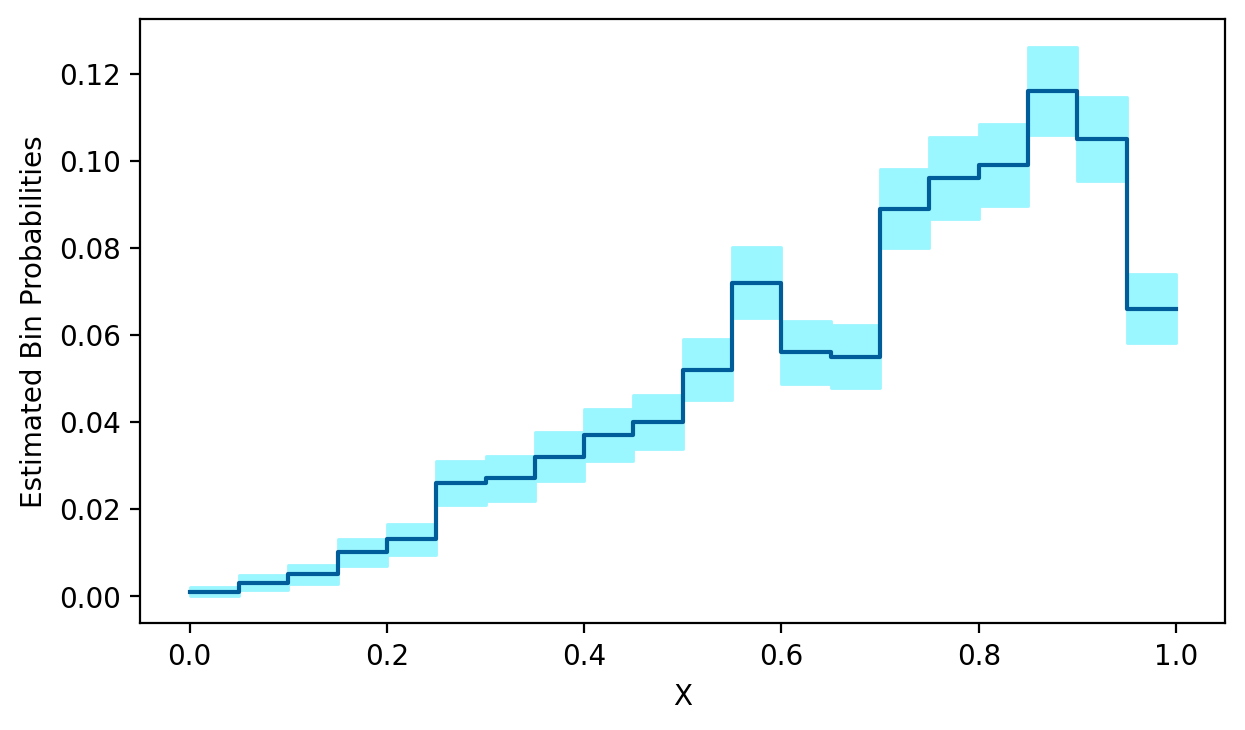

In [185]:
fig_logit_hist

## Changing scale we can compare it with analytical pushforward

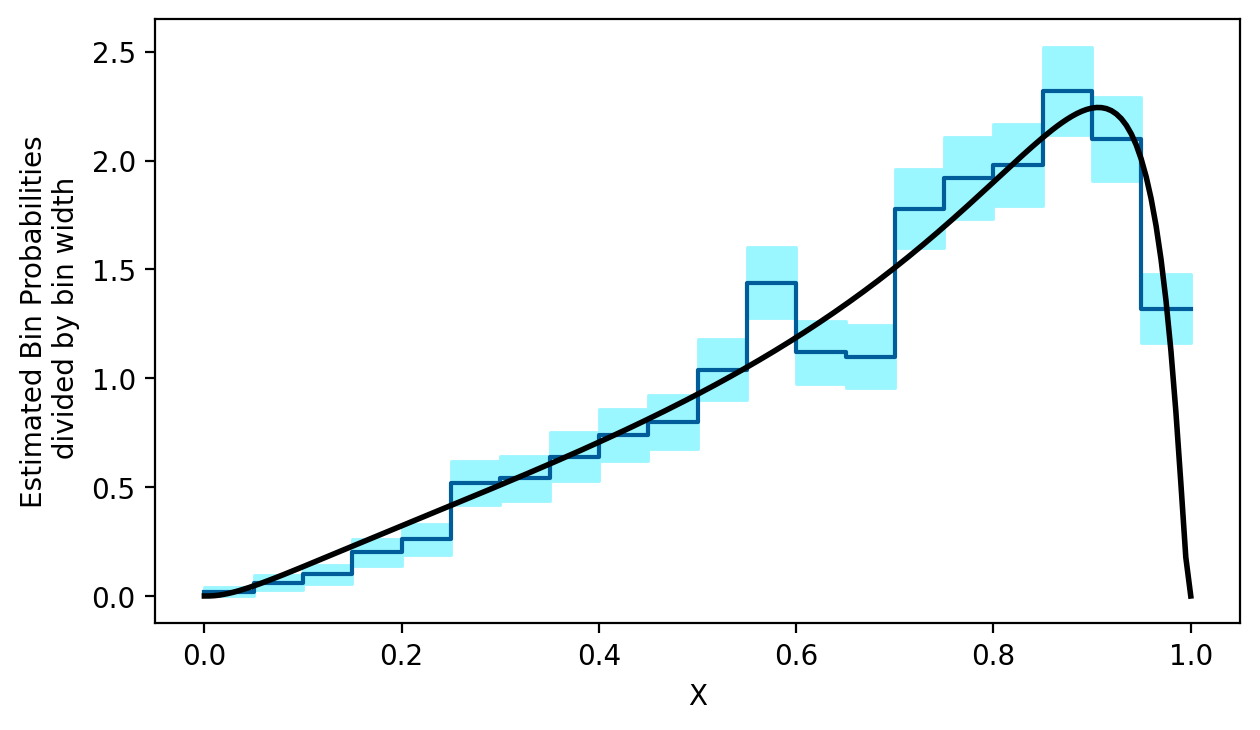

In [186]:
bins = np.linspace(0,1,21)
new_bins, probs,mc_se = mc_hist(sample_pushforward,bins)
fig_logit_analytical,ax = plt.subplots(1,1,figsize = (7,4))

xs = np.linspace(1e-6,1-1e-6,200)
analytical = stats.norm.pdf(logit(xs),1,1.25)/(xs*(1-xs))
ax = mc_hist_plot(new_bins, probs,mc_se,ax,scale=True)
ax.plot(xs,analytical,color='black',linewidth=2)
fig_logit_analytical.savefig('../markdown/img/fig_logit_analytical.png')


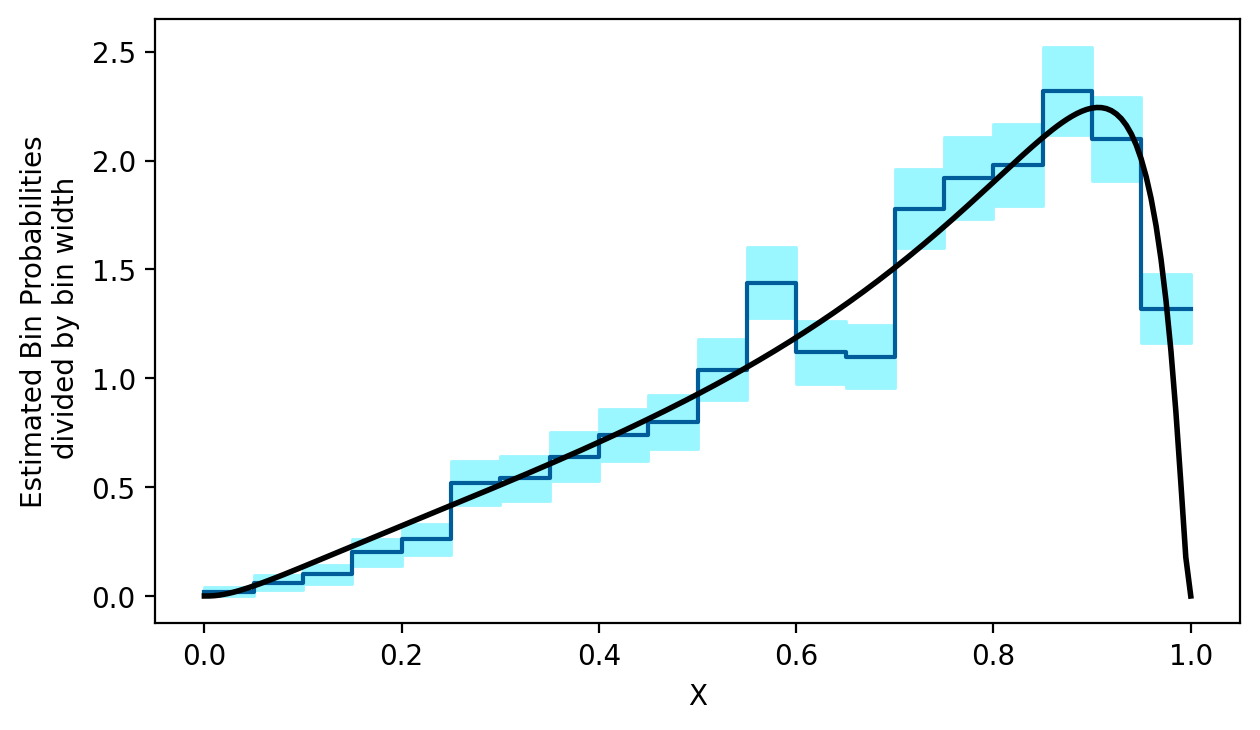

In [187]:
fig_logit_analytical

## ECDF for completness

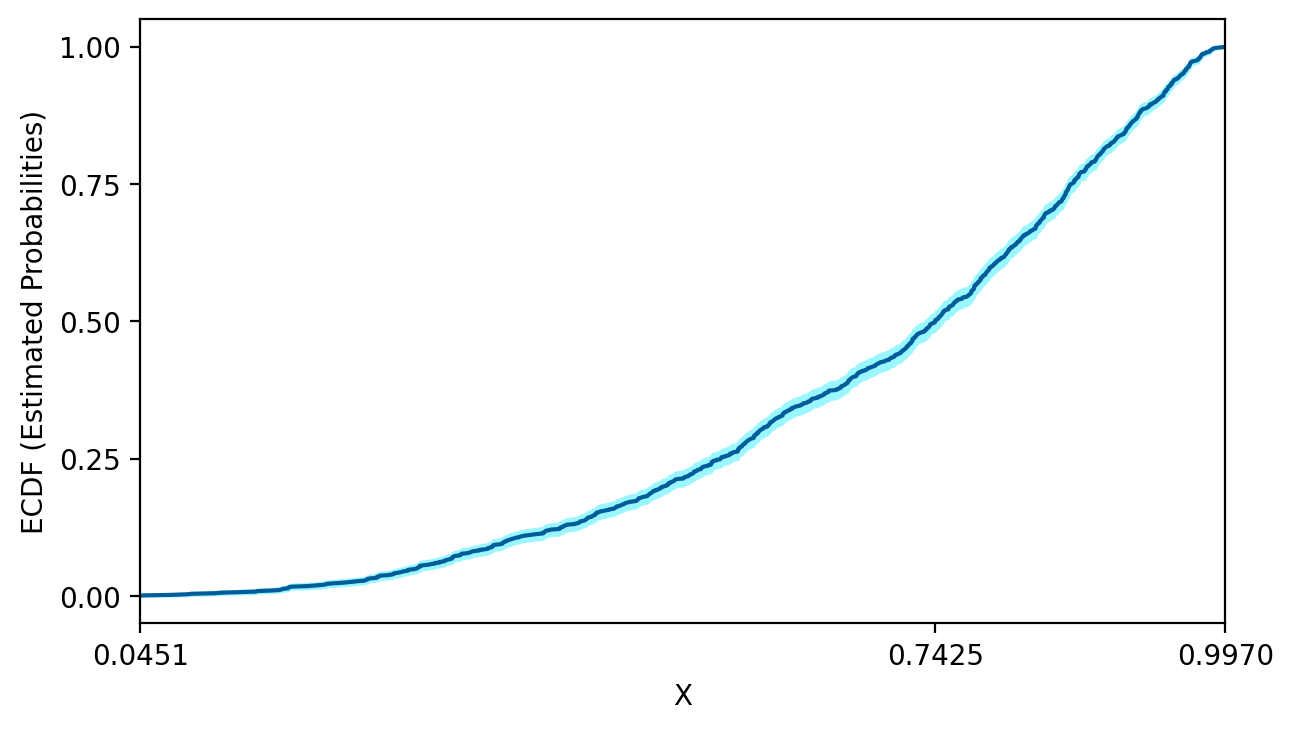

In [188]:
values, probs, mc_se = mc_ecdf(sample_pushforward)

fig_logit_ecdf,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_ecdf_plot(values, probs, mc_se,ax)
plt.show()
fig_logit_ecdf.savefig('../markdown/img/fig_logit_ecdf.png')


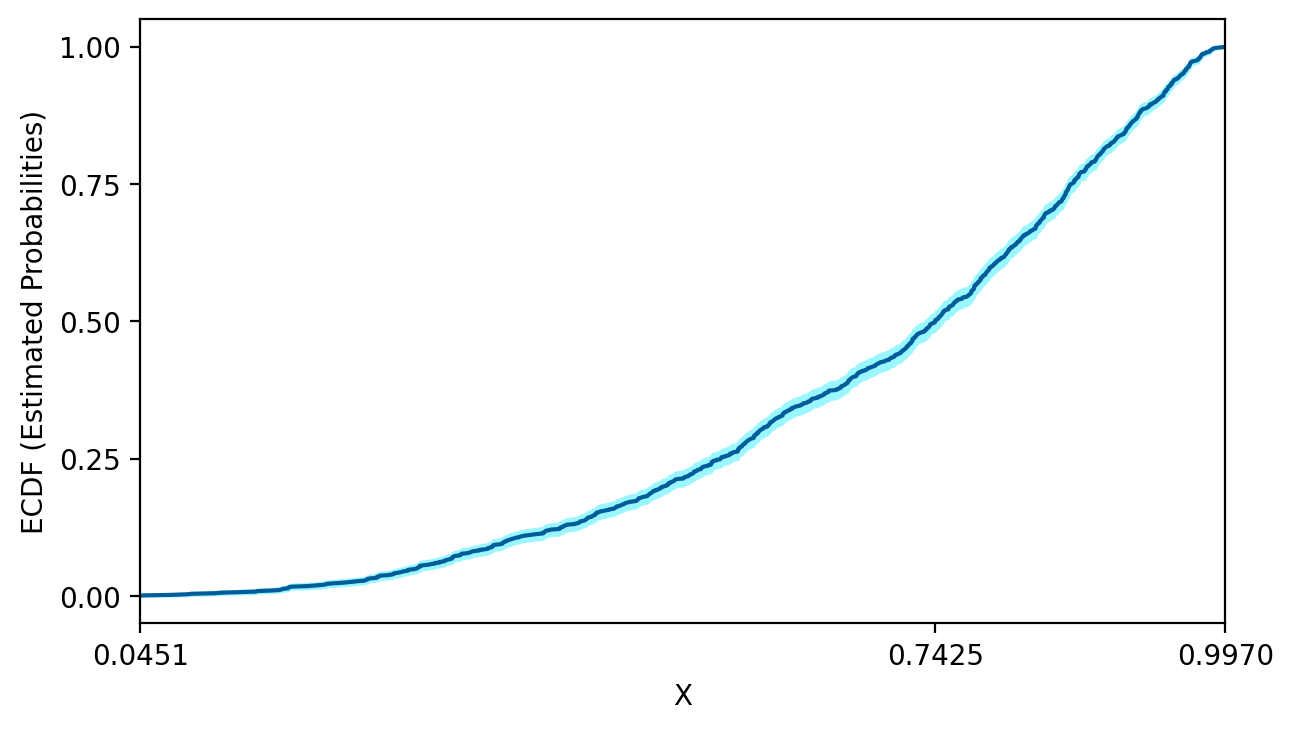

In [189]:
fig_logit_ecdf

## Example 3 - heavy tailed distribution with undefined mean and variance

In the next series of examples we will be considerning Student's t probability density function,

$$
\pi(x ; \nu) =
\frac{1}{ \sqrt{\pi \, \nu } }
\frac{\Gamma(\frac{\nu + 1}{2})}
{ \Gamma(\frac{\nu}{2}) }
\left(1 + \frac{x^2}{\nu} 
\right)^{- \cfrac{\nu + 1}{2}}.
$$

Its expectation and variance are:

$$
\mathbb{E}_\pi[x] = \begin{cases}
    0& \text{for}\ \nu > 1\\
    \text{undefined}& \text{otherwise}                
\end{cases}
$$

$$
\mathbb{V}_\pi[x] = \begin{cases}
    \frac{\nu}{\nu-2}& \text{for}\ \nu > 2\\
    \infty& \text{for}\ \nu (1,2]\\
    \text{undefined}& \text{otherwise}                
\end{cases}
$$


Special case for $\nu=1$ is called the Cauchy distribution
```python
from numpy.random import standard_t
sample_student_inf_variance = standard_t(df = 1.5,size = 1000)
```


## How to sample

```python
from numpy.random import standard_t
sample_cauchy = standard_t(df = 1,size = 1000)
```

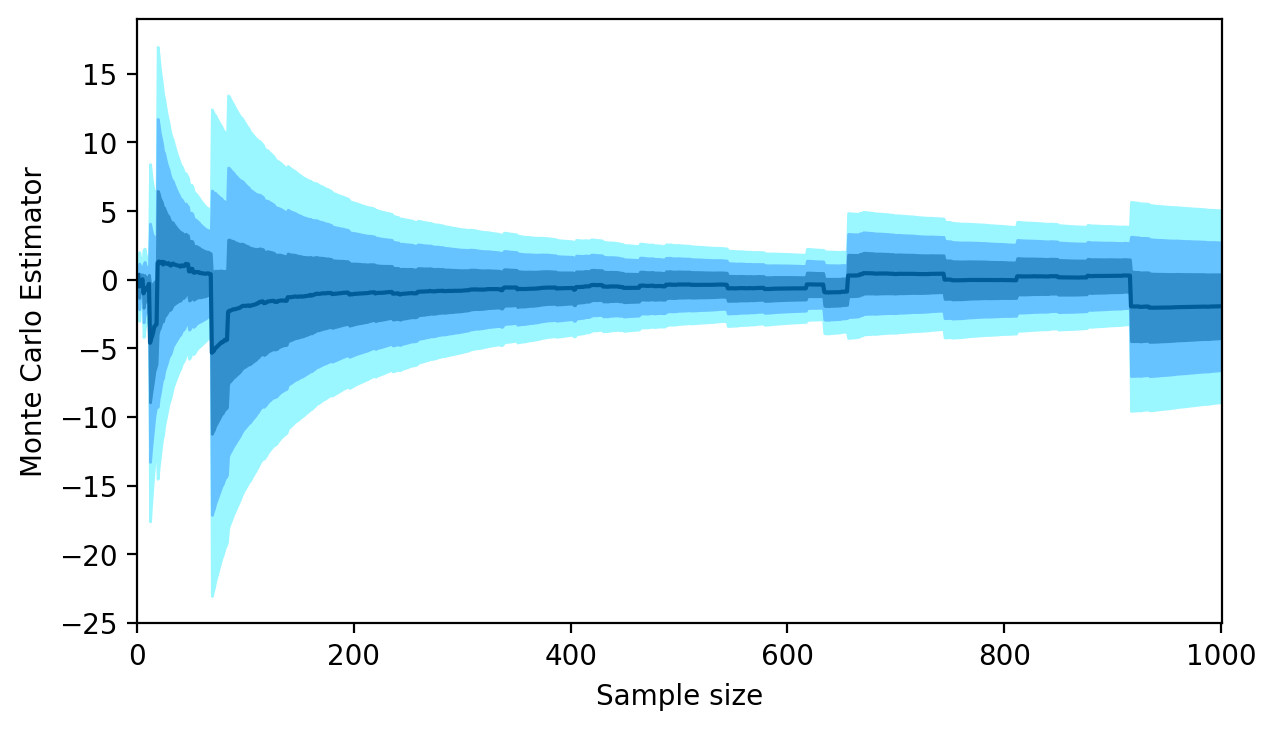

In [190]:
np.random.seed(10052021)
sample_cauchy = standard_t(df = 1,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_cauchy)

fig_rolling_cauchy,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()
fig_rolling_cauchy.savefig('../markdown/img/fig_rolling_cauchy.png')


## Expectation of Cauchy samples behaves weirdly

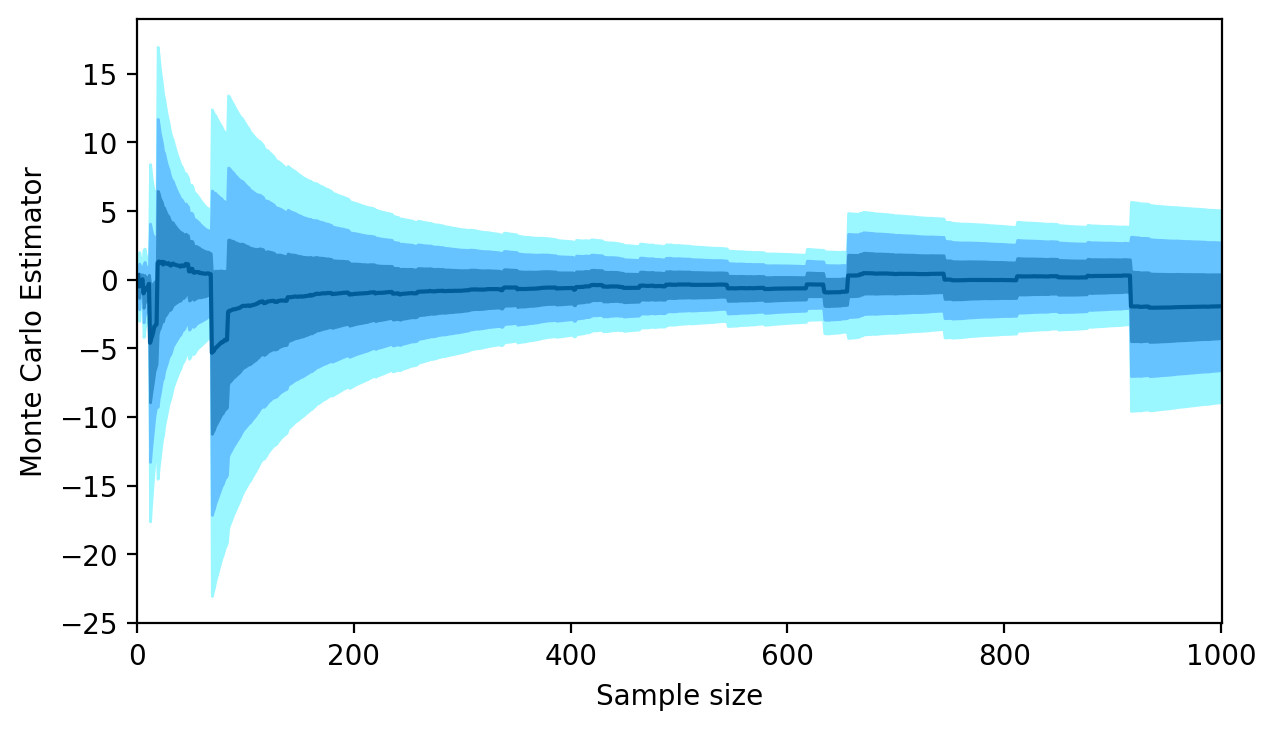

In [191]:
fig_rolling_cauchy

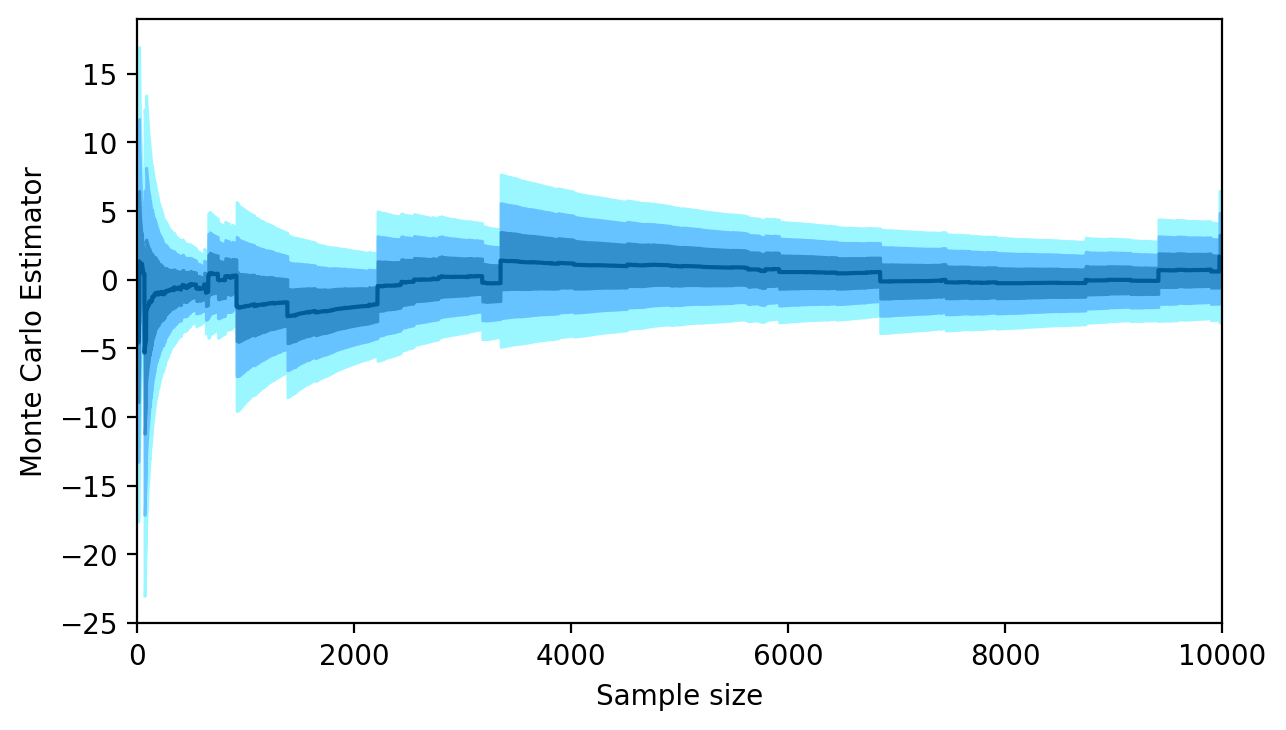

In [192]:
sample_cauchy_long = np.hstack((sample_cauchy,standard_t(df = 1,size = 9000)))


rolling_mean, rolling_mcse = rolling_stats(sample_cauchy_long)

fig_rolling_cauchy_long,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

fig_rolling_cauchy_long.savefig('../markdown/img/fig_rolling_cauchy_long.png')


## Increase of number of samples does not improve situation

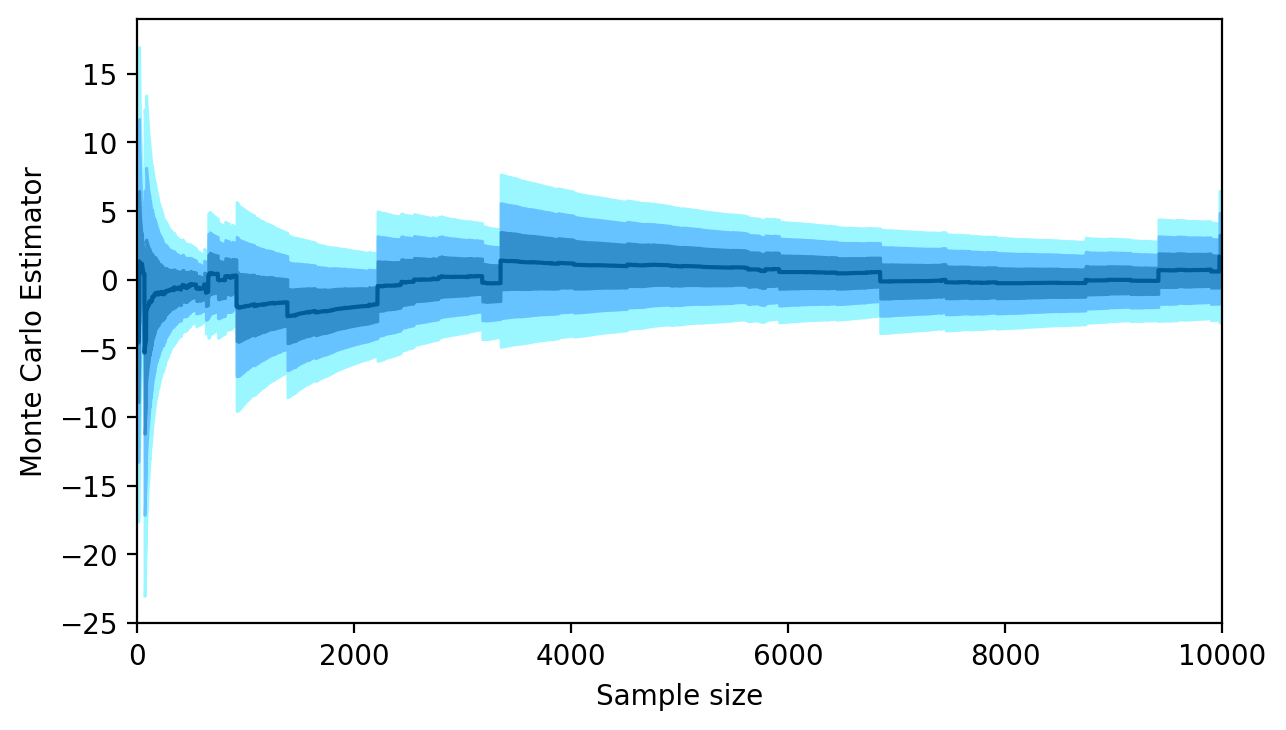

In [193]:
fig_rolling_cauchy_long

In [194]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 1,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))


## Does central limit theorem even hold?

Monte Carlo computation is generally based on Central Limit Theorem. If it holds, then the estimator standarized by the Monte Carlo standard error should be normally distributed around true expectation

$$
\frac{ \hat{f}_{N}^{\text{MC}} - \mathbb{E}_{\pi}[f] }
{\text{MC-SE}_{N}[f] } 
\sim \mathcal{N}(0, 1),
$$
So we can analyze multiple samples and analyze histogram of the estimator

```python
for r in range(R):
    sample = standard_t(df = 1,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))
```



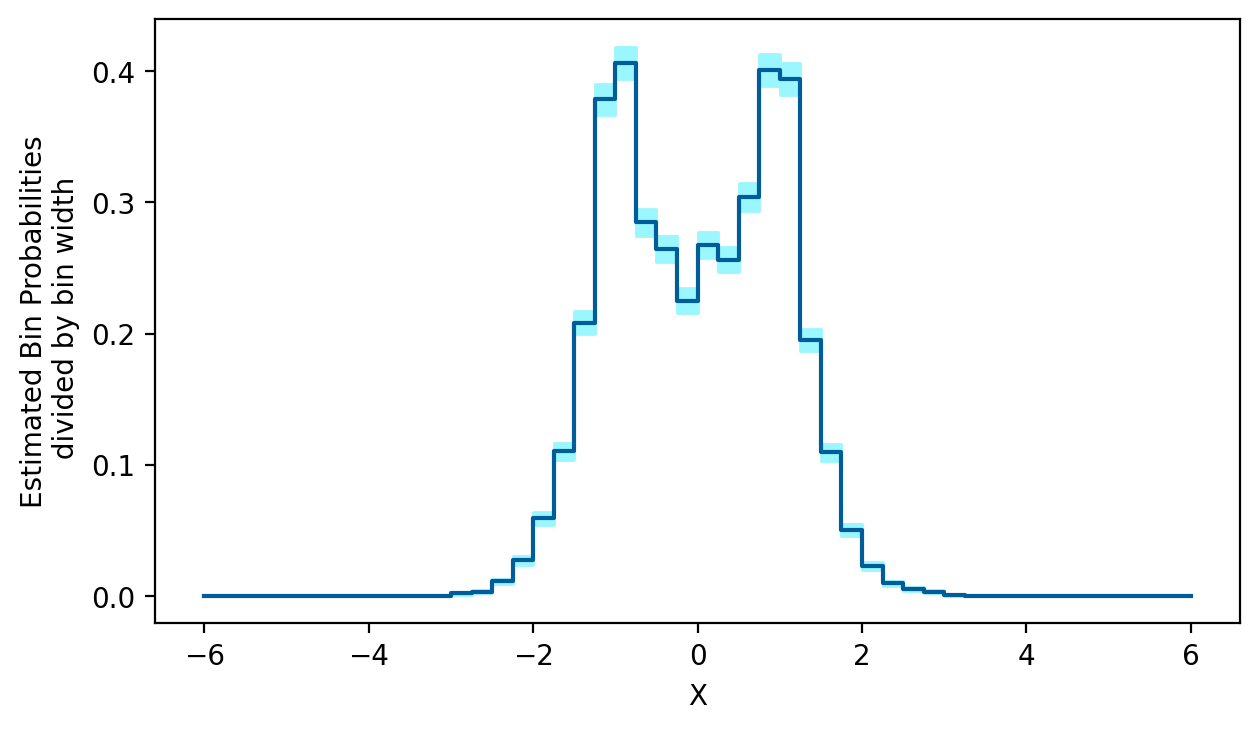

In [195]:
fig_cauchy_estimator,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)
fig_cauchy_estimator.savefig('../markdown/img/fig_cauchy_estimator.png')



## That's not normal!

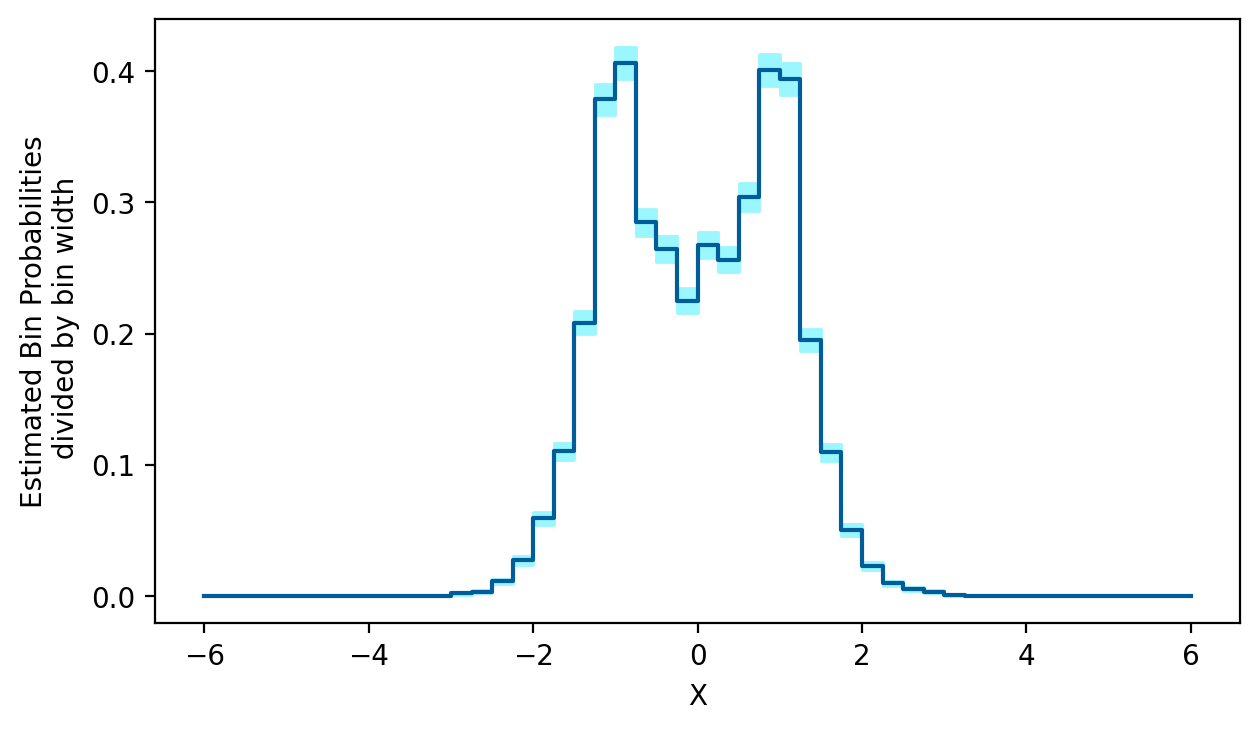

In [196]:
fig_cauchy_estimator

## Are such distributions useless?

Probabilities are still well defined. Let us consider a pushforward for an indicator function of $(-1,0)$ interval.

```python
indicator = lambda x: 1 if (x>-1 and x<0) else 0
sample_pushforward = np.vectorize(indicator)(sample_cauchy)
```


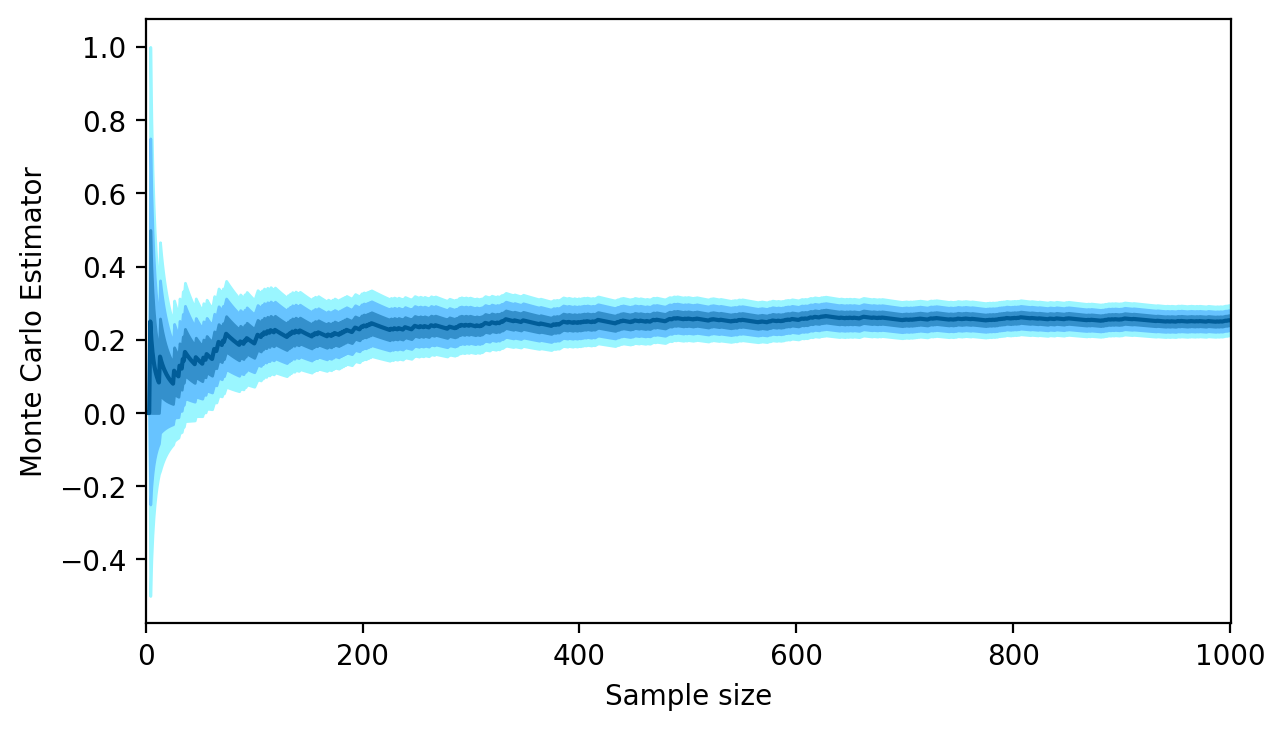

In [197]:
indicator = lambda x: 1 if (x>-1 and x<0) else 0
sample_pushforward = np.vectorize(indicator)(sample_cauchy)

rolling_mean, rolling_mcse = rolling_stats(sample_pushforward)

fig_rolling_prob,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()
fig_rolling_prob.savefig('../markdown/img/fig_rolling_prob.png')


## Probability is well behaved

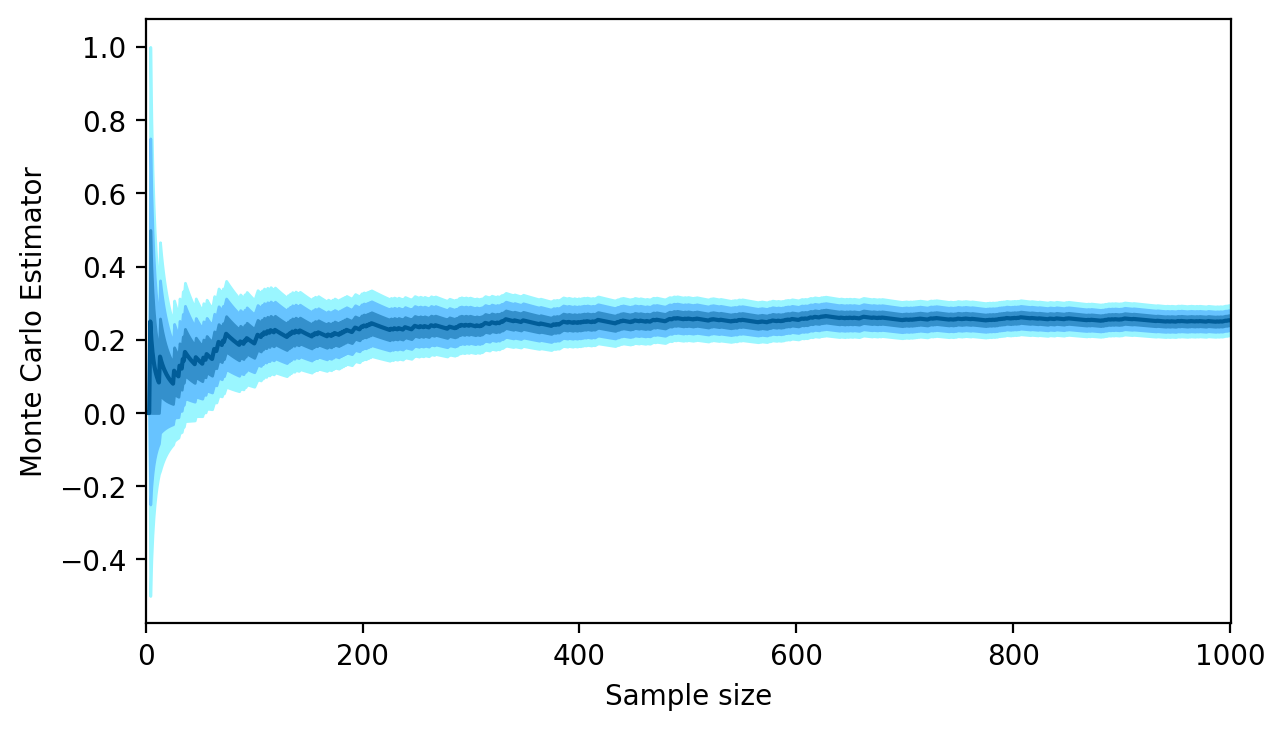

In [198]:
fig_rolling_prob

In [199]:
prob_stats = pd.DataFrame({'MC_Est':rolling_mean[-1],'MCSE':rolling_mcse[-1]},index=['Indicator'])


## Errors are also well quantified

In [200]:
prob_stats

MC_Est      MCSE
Indicator   0.253  0.013754

## Example 4 - infinite variance

We continue with Student-t distribution, but this time with well defined mean
```python
sample_student_inf_variance = standard_t(df = 1.5,size = 1000)
```

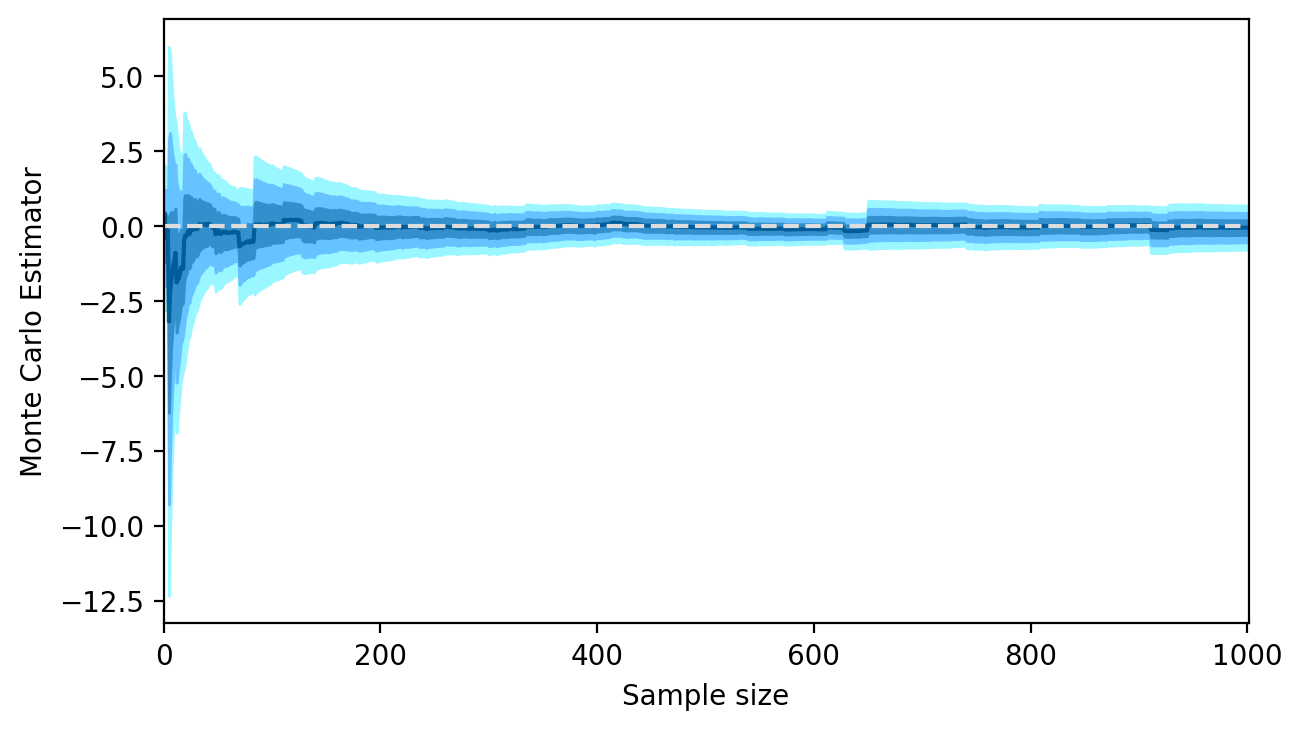

In [201]:
np.random.seed(10052021)


sample_student_inf_variance = standard_t(df = 1.5,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_student_inf_variance)

fig_rolling_inf_variance,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
ax.plot([1,1000],[0,0],color=LIGHT_GREY,linestyle='--')
plt.show()
fig_rolling_inf_variance.savefig('../markdown/img/fig_rolling_inf_variance.png')


## Infinite variance of distribution causes jumps in the uncertianity

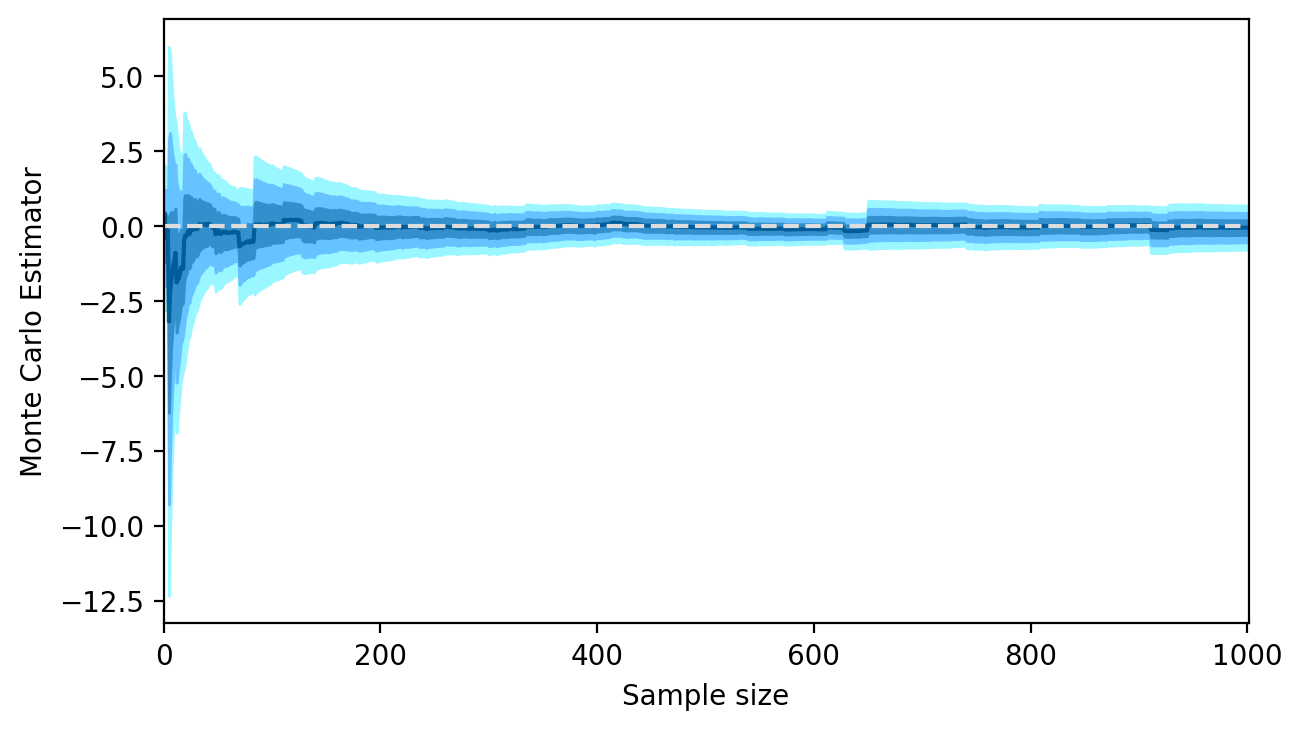

In [202]:
fig_rolling_inf_variance

In [203]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 1.5,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))

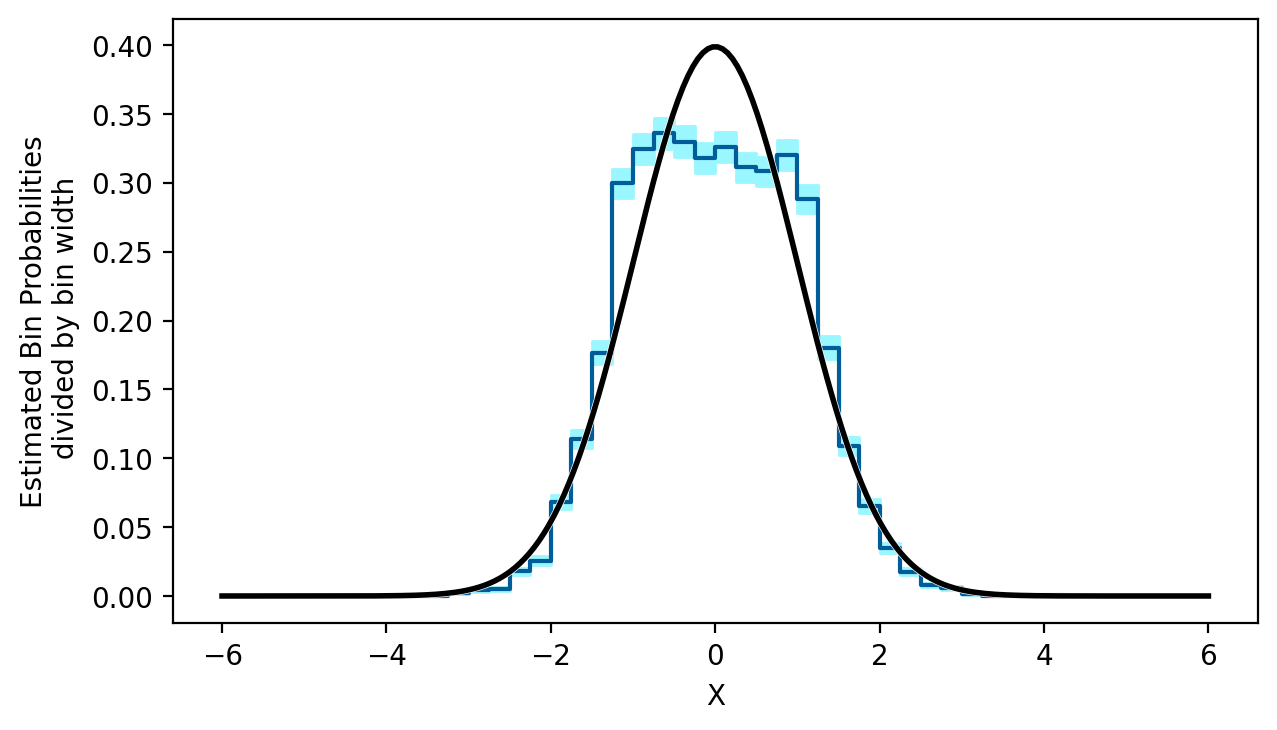

In [204]:
new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
fig_estimator_inf_variance,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='white',linewidth=2.5)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='black',linewidth=2)

fig_estimator_inf_variance.savefig('../markdown/img/fig_estimator_inf_variance.png')


## Not normal - Error quantification is unreliable

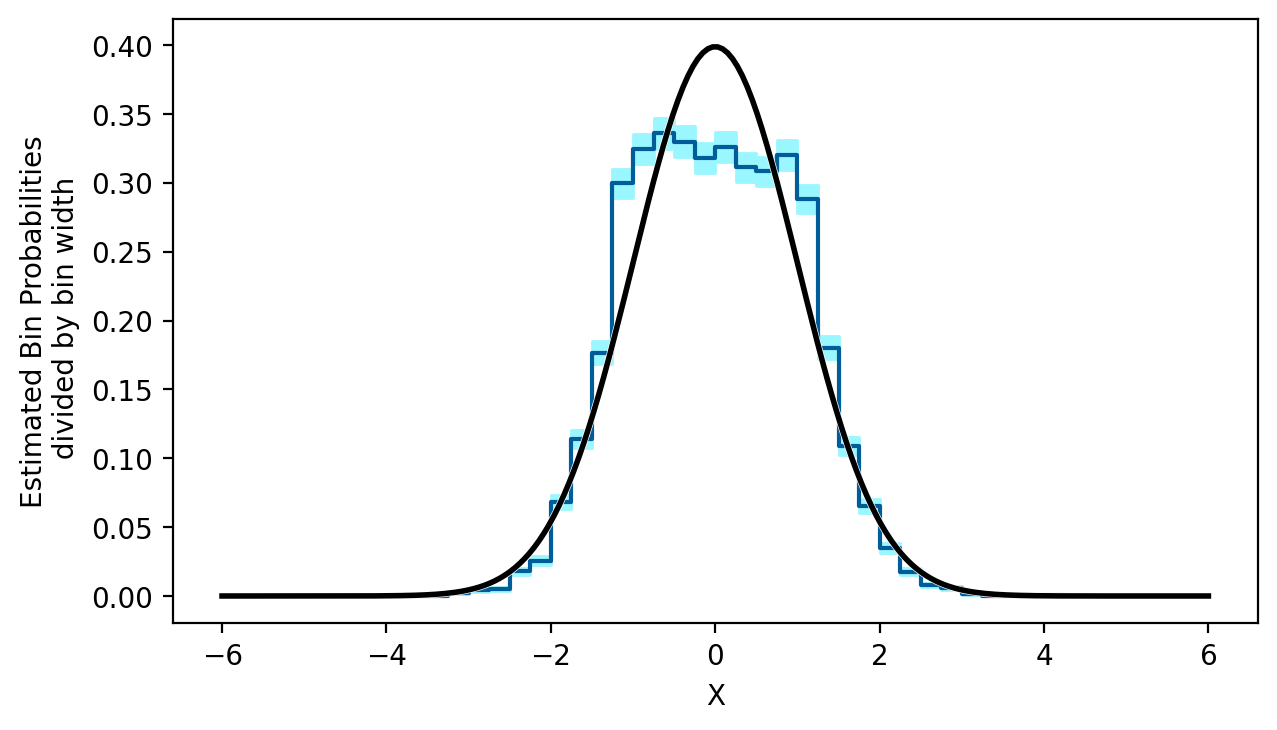

In [205]:
fig_estimator_inf_variance

## Example 5 - well behaved mean and variance

We conclude with Student-t distribution with 3 degrees of freedom
```python
sample_student = standard_t(df = 3,size = 1000)
```

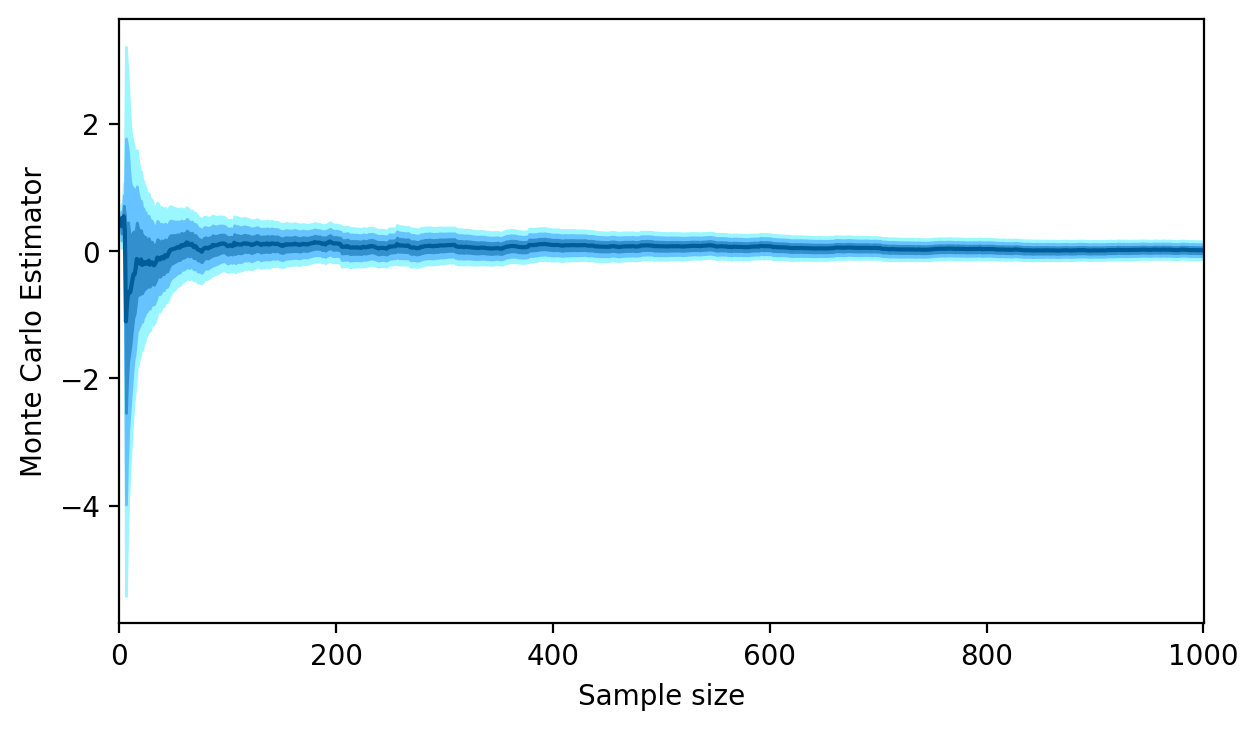

In [206]:
sample_student = standard_t(df = 3,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_student)

fig_rolling_student,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

fig_rolling_student.savefig('../markdown/img/fig_rolling_student.png')


## Estimator behaves reasonably

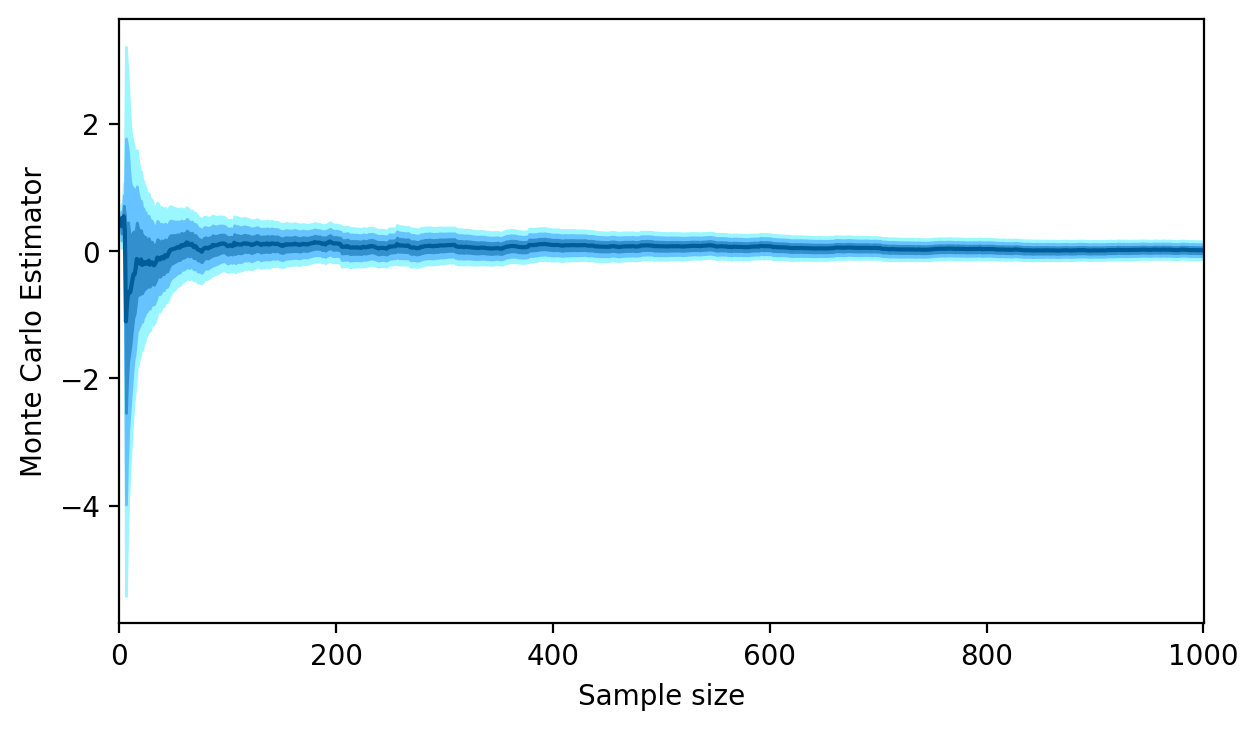

In [207]:
fig_rolling_student

In [208]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 3,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))

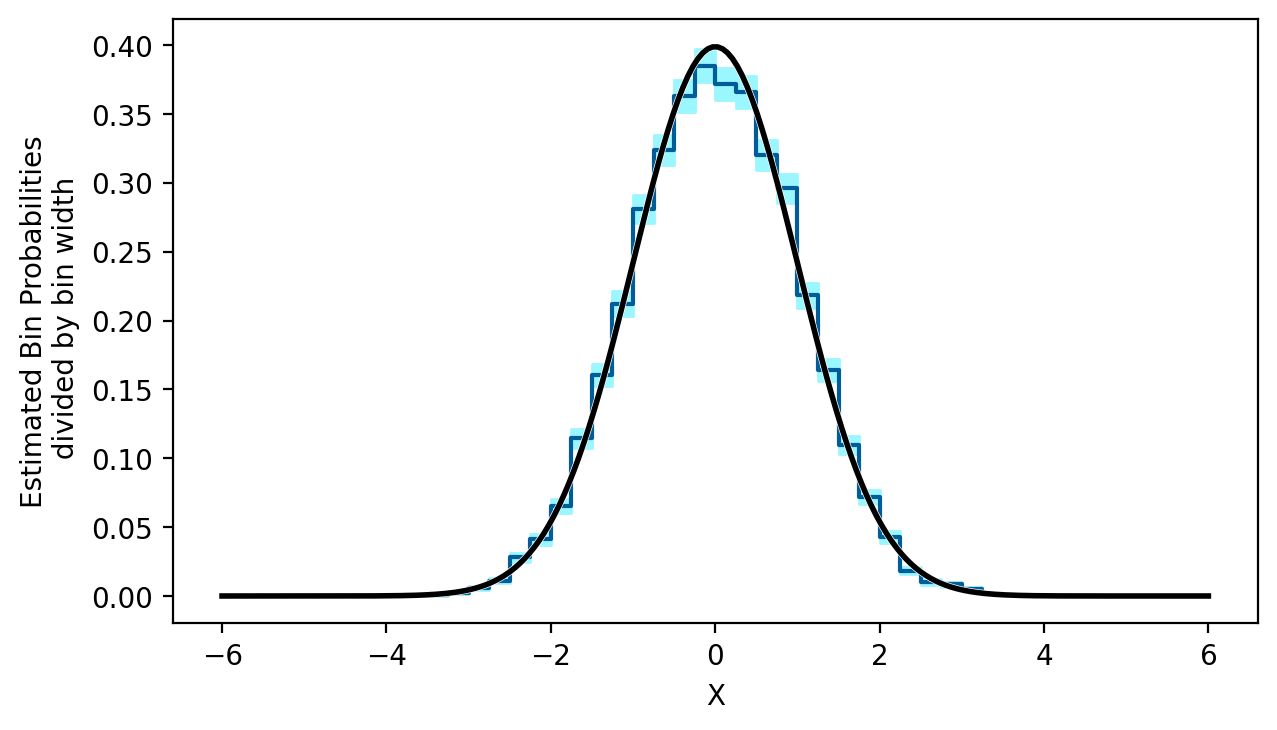

In [209]:
new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
fig_estimator_student,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='white',linewidth=2.5)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='black',linewidth=2)
fig_estimator_student.savefig('../markdown/img/fig_estimator_student.png')


## We can empirically confirm central limit theorem

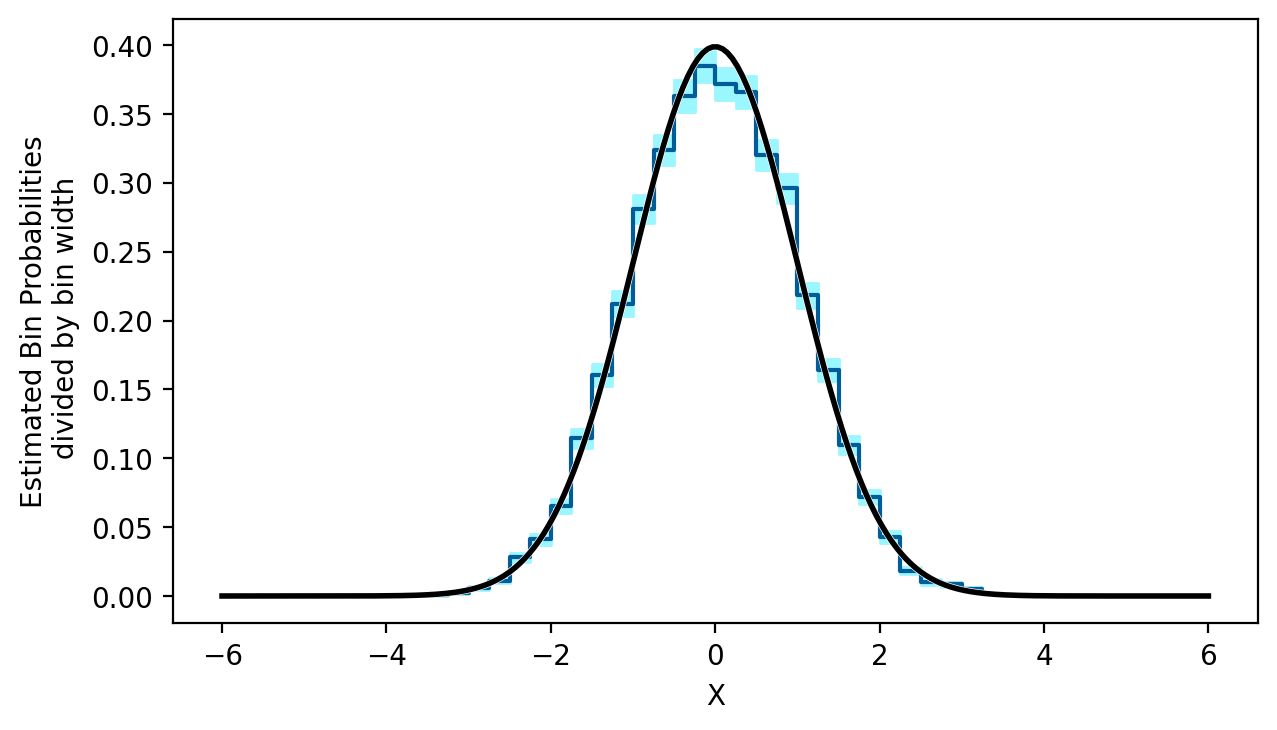

In [210]:
fig_estimator_student

## Quantifying tail behavior

Generalized Pareto distribution

$$
\pi(x) = \begin{cases}
\frac{1}{\sigma}(1 - \frac{k}{\sigma} z)^{\frac{1}{k}-1} & \text{for }k \neq 0, \\
\frac{1}{\sigma}e^{-x/\sigma} & \text{for }k = 0.
\end{cases}
$$

It is a good model for extreme values, in particular it is widely used to determine if samples come from 'heavy tailed' distribution.

## $\hat{k}$ as a test function
We use a point estimator $\hat{k}$ (by Zhang and Stephens) as a check for problems. We fit $\hat{k}$ for tail of each distribution. 

As a rule of thumb: 
- Tails with $\hat{k}>0.7$ it is really problematic
- $\hat{k} <0.25$ is a sensible threshold 

In [211]:
from math import floor
def k_hat (x):
    N = len(x)
    x = np.array(sorted(x))
    if x[0]<=0:
        raise ValueError('x must be positive')
    q = x[floor(0.25*N+0.5)-1]
    M = 20 + floor(np.sqrt(N))
    b_hat_vec = np.zeros(M)
    log_w_vec = np.zeros(M)

    for m in range(M):
        b_hat_vec[m] = 1 / x[-1] + (1 - np.sqrt(M / (m + 0.5))) / (3 * q)
        k_hat = - np.mean(np.log(1-b_hat_vec[m]*x))
        log_w_vec[m] = N*(np.log(b_hat_vec[m]/k_hat)+k_hat-1)
    max_log_w = np.max(log_w_vec)
    b_hat = np.sum(b_hat_vec*np.exp(log_w_vec-max_log_w))/np.sum(np.exp(log_w_vec-max_log_w))
    return np.mean(np.log(1-b_hat*x))

## We split distribution into tails

In [212]:
def tail_khats(x):
    x_center = np.median(x)
    if (x_center==np.min(x) or x_center==np.max(x)):
        return (0,0)
    x_left = np.abs(x[x<=x_center]-x_center)
    x_right = x[x>=x_center]-x_center

    return k_hat(x_left),k_hat(x_right)

In [213]:
tail_khats(sample_student)

index = ['Cauchy - small sample','Cauchy', 'Student-T - nu=1.5', 'Student-T - nu=3','Normal']

samples = [sample_cauchy,sample_cauchy_long,sample_student_inf_variance,sample_student,sample_normal]
left = [tail_khats(x)[0] for x in samples]
right = [tail_khats(x)[1] for x in samples]
khat_summary = pd.DataFrame({'Left Tail khat':left,'Right Tail khat':right},index=index)

In [214]:
khat_summary

Left Tail khat  Right Tail khat
Cauchy - small sample        0.849733         0.764180
Cauchy                       0.753889         0.770996
Student-T - nu=1.5           0.478854         0.470341
Student-T - nu=3             0.003987         0.060753
Normal                      -0.270489        -0.205470

## Main takeaways

- Monte Carlo sampling, as long as distribution is well posed offers valuable estimates and error quantification
- Any probability estimate has its own error
- If samples are not consistent or distribution lacks necessary moments issues can happen
- There are possible diagnostics of tail behavior that can lead to useful guidelines
- Multidimensional sampling requires more tools -> MCMC 


## Extra reading

- Much more about sampling and further examples and deeper theory can be found in [Rumble in the ensemble](https://betanalpha.github.io/assets/case_studies/sampling.html) by Michael Betancourt
- $\hat{k}$ estimator - Zhang, J. and Stephens, M. A. (2009). A new and efficient estimation method for the generalized pareto distribution. Technometrics 51 316–25.
- Mersenne Twister - Matsumoto, M. and Nishimura, T. (1998). Mersenne twister: A 623-dimensionally equidistributed uniform pseudo-random number generator. ACM Trans. Model. Comput. Simul. 8 3–30. [Also wikipedia](https://en.wikipedia.org/wiki/Mersenne_Twister)

## Over and under fitting of the typical set

<img src="img/overestimated_var.png" alt="drawing" width="500"/>
<img src="img/underestimated_var.png" alt="drawing" width="500"/>
<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>